In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, SGDRegressor
from nn_model import *
from nn_train import *

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, mean_squared_error
from config import *

import xgboost as xgb

import os

import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import joblib

import shap
shap.initjs()

Using mps


# Preprocessing

In [3]:
df = pd.read_csv(data_dir + 'openaq_merra2_all.csv')
df = df.dropna(axis=0).reset_index(drop=True)
df

,openaq_pm25,openaq_time,parameter,units,site_id,site_name,lat,lon,DUEXTTAU,SSSMASS25,...,Q500,T10M,Q850,V2M,V10M,T850,U10M,QV2M,QV10M,PBLH
0,31.0,2019-10-28 18:59:59,pm25,µg/m³,8839,Baghdad Airnow,33.3128,44.3615,0.126073,1.429726e-09,...,0.000599,294.997040,0.007774,0.540911,1.267893,285.016174,-1.380577,0.008615,0.008593,103.362801
1,44.0,2019-10-28 20:59:59,pm25,µg/m³,8839,Baghdad Airnow,33.3128,44.3615,0.122747,1.508852e-09,...,0.000338,293.673523,0.007294,0.649250,1.517674,285.104523,-1.187964,0.008766,0.008760,65.157997
2,27.0,2019-10-28 21:59:59,pm25,µg/m³,8839,Baghdad Airnow,33.3128,44.3615,0.120642,1.512490e-09,...,0.000241,293.124237,0.006970,0.599674,1.396908,285.223206,-1.256243,0.008892,0.008886,65.026810
3,20.0,2019-10-28 23:59:59,pm25,µg/m³,8839,Baghdad Airnow,33.3128,44.3615,0.117869,1.527496e-09,...,0.000234,292.179321,0.006365,0.467283,1.087632,285.518616,-1.540468,0.009197,0.009151,64.812714
4,15.0,2019-10-29 00:59:59,pm25,µg/m³,8839,Baghdad Airnow,33.3128,44.3615,0.117735,1.501121e-09,...,0.000227,291.771790,0.006159,0.438826,1.023955,285.631927,-1.615325,0.009353,0.009303,64.731140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,2024-08-31 19:59:59,pm25,µg/m³,8881,Uzbekistan,41.3672,69.2725,0.075855,1.253397e-10,...,0.000185,294.898224,0.004684,-0.385406,-0.840388,292.366333,-1.672649,0.004759,0.004759,90.612373
303515,8.0,2024-08-31 20:59:59,pm25,µg/m³,8881,Uzbekistan,41.3672,69.2725,0.067616,1.339799e-10,...,0.000234,294.655670,0.004707,-0.354869,-0.739873,291.882599,-1.459667,0.004782,0.004782,153.561401
303516,8.0,2024-08-31 21:59:59,pm25,µg/m³,8881,Uzbekistan,41.3672,69.2725,0.059099,1.411991e-10,...,0.000281,294.347656,0.004721,-0.439029,-0.874943,291.571838,-1.334082,0.004801,0.004801,163.961914
303517,7.0,2024-08-31 22:59:59,pm25,µg/m³,8881,Uzbekistan,41.3672,69.2725,0.051028,1.468834e-10,...,0.000300,294.054321,0.004738,-0.557936,-1.089334,291.454865,-1.265444,0.004816,0.004816,259.934357


In [22]:
df['site_name'].value_counts()

site_name
Kuwait                 53989
Bahrain                42291
Uzbekistan             40507
Tajikistan Dushanbe    35241
Tajikistan Embassy     32183
Baghdad Embassy        31246
Turkmenistan           28493
Baghdad Airnow         24738
Doha                   11347
Kyrgyzstan              2607
Dubai                    877
Name: count, dtype: int64

In [3]:
df.columns

Index(['openaq_pm25', 'openaq_time', 'parameter', 'units', 'site_id',
       'site_name', 'lat', 'lon', 'DUEXTTAU', 'SSSMASS25', 'SSSMASS',
       'OCSMASS', 'BCSMASS', 'SSEXTTAU', 'TOTEXTTAU', 'BCEXTTAU', 'SUEXTTAU',
       'OCEXTTAU', 'SO4SMASS', 'DUSMASS', 'DUSMASS25', 'U2M', 'T500', 'PS',
       'Q500', 'T10M', 'Q850', 'V2M', 'V10M', 'T850', 'U10M', 'QV2M', 'QV10M',
       'PBLH'],
      dtype='object')

In [4]:
def cyclical_encoding(value, max_value):
    sin_val = np.sin(2 * np.pi * value / max_value)
    cos_val = np.cos(2 * np.pi * value / max_value)
    return sin_val, cos_val

# Only MERRA-2

In [3]:
df_merra2 = df.drop(['openaq_time', 'parameter', 'units', 'site_id', 'site_name', 'lat', 'lon'], axis=1)
df_merra2 = df_merra2.dropna(axis=0).reset_index(drop=True)
df_merra2

,openaq_pm25,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,...,Q500,T10M,Q850,V2M,V10M,T850,U10M,QV2M,QV10M,PBLH
0,31.0,0.126073,1.429726e-09,5.351467e-09,3.163245e-09,2.020898e-09,0.008144,0.426803,0.019652,0.251693,...,0.000599,294.997040,0.007774,0.540911,1.267893,285.016174,-1.380577,0.008615,0.008593,103.362801
1,44.0,0.122747,1.508852e-09,5.791662e-09,3.317858e-09,2.313763e-09,0.007917,0.406415,0.019223,0.236378,...,0.000338,293.673523,0.007294,0.649250,1.517674,285.104523,-1.187964,0.008766,0.008760,65.157997
2,27.0,0.120642,1.512490e-09,5.928086e-09,3.361499e-09,2.416527e-09,0.007769,0.393258,0.018845,0.226432,...,0.000241,293.124237,0.006970,0.599674,1.396908,285.223206,-1.256243,0.008892,0.008886,65.026810
3,20.0,0.117869,1.527496e-09,6.206392e-09,3.405203e-09,2.480193e-09,0.007383,0.367618,0.017699,0.206367,...,0.000234,292.179321,0.006365,0.467283,1.087632,285.518616,-1.540468,0.009197,0.009151,64.812714
4,15.0,0.117735,1.501121e-09,6.260962e-09,3.333298e-09,2.429260e-09,0.007303,0.359478,0.017112,0.199644,...,0.000227,291.771790,0.006159,0.438826,1.023955,285.631927,-1.615325,0.009353,0.009303,64.731140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,0.075855,1.253397e-10,3.760761e-10,1.492945e-09,1.799678e-10,0.001118,0.144343,0.006756,0.046716,...,0.000185,294.898224,0.004684,-0.385406,-0.840388,292.366333,-1.672649,0.004759,0.004759,90.612373
303515,8.0,0.067616,1.339799e-10,4.026788e-10,1.543898e-09,1.863947e-10,0.001032,0.134482,0.006448,0.045798,...,0.000234,294.655670,0.004707,-0.354869,-0.739873,291.882599,-1.459667,0.004782,0.004782,153.561401
303516,8.0,0.059099,1.411991e-10,4.242793e-10,1.603029e-09,1.929955e-10,0.000930,0.123381,0.006206,0.044007,...,0.000281,294.347656,0.004721,-0.439029,-0.874943,291.571838,-1.334082,0.004801,0.004801,163.961914
303517,7.0,0.051028,1.468834e-10,4.401954e-10,1.657658e-09,1.988664e-10,0.000820,0.112261,0.006061,0.041682,...,0.000300,294.054321,0.004738,-0.557936,-1.089334,291.454865,-1.265444,0.004816,0.004816,259.934357


In [4]:
train_val_data, test_data = train_test_split(df_merra2, test_size=0.1, random_state=497)
train_data, val_data = train_test_split(train_val_data, test_size=0.1, random_state=497)
X_train = train_data.drop('openaq_pm25', axis=1)
y_train = train_data['openaq_pm25']
X_val = val_data.drop('openaq_pm25', axis=1)
y_val = val_data['openaq_pm25']
X_test = test_data.drop('openaq_pm25', axis=1)
y_test = test_data['openaq_pm25']

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(245850, 26)
(245850,)
(27317, 26)
(27317,)
(30352, 26)
(30352,)


In [2]:
np.save(data_dir + 'X_train.npy', X_train.to_numpy())
np.save(data_dir + 'y_train.npy', y_train.to_numpy())
np.save(data_dir + 'X_val.npy', X_val.to_numpy())
np.save(data_dir + 'y_val.npy', y_val.to_numpy())
np.save(data_dir + 'X_test.npy', X_test.to_numpy())
np.save(data_dir + 'y_test.npy', y_test.to_numpy())

NameError: name 'X_train' is not defined

In [14]:
X_train = np.load(nn_data_dir + 'X_train.npy')
y_train = np.load(nn_data_dir + 'y_train.npy')
X_val = np.load(nn_data_dir + 'X_val.npy')
y_val = np.load(nn_data_dir + 'y_val.npy')
X_test = np.load(nn_data_dir + 'X_test.npy')
y_test = np.load(nn_data_dir + 'y_test.npy')

In [29]:
df_merra2_subset, _ = train_test_split(df_merra2, train_size=0.1, random_state=497)
train_subset, val_subset = train_test_split(df_merra2_subset, test_size=0.3, random_state=497)
X_train_subset = train_subset.drop('openaq_pm25', axis=1)
y_train_subset = train_subset['openaq_pm25']
X_val_subset = val_subset.drop('openaq_pm25', axis=1)
y_val_subset = val_subset['openaq_pm25']

In [30]:
print(X_train_subset.shape)
print(y_train_subset.shape)
print(X_val_subset.shape)
print(y_val_subset.shape)

(21245, 26)
(21245,)
(9106, 26)
(9106,)


In [31]:
np.save(data_dir + 'X_train_subset.npy', X_train_subset.to_numpy())
np.save(data_dir + 'y_train_subset.npy', y_train_subset.to_numpy())
np.save(data_dir + 'X_val_subset.npy', X_val_subset.to_numpy())
np.save(data_dir + 'y_val_subset.npy', y_val_subset.to_numpy())

In [3]:
X_train_subset = np.load(data_dir + 'X_train_subset.npy')
y_train_subset = np.load(data_dir + 'y_train_subset.npy')
X_val_subset = np.load(data_dir + 'X_val_subset.npy')
y_val_subset = np.load(data_dir + 'y_val_subset.npy')

# Transformation 1

Add cyclical encoding to date.

In [4]:
df_time = df.drop(['parameter', 'units', 'site_id', 'site_name', 'lat', 'lon'], axis=1)
df_time['openaq_time'] = pd.to_datetime(df_time['openaq_time'])
df_time['hour_sin'], df_time['hour_cos'] = zip(*df_time['openaq_time'].dt.hour.apply(lambda x: cyclical_encoding(x, 24)))
df_time['day_sin'], df_time['day_cos'] = zip(*df_time['openaq_time'].dt.dayofweek.apply(lambda x: cyclical_encoding(x, 7)))
df_time['month_sin'], df_time['month_cos'] = zip(*df_time['openaq_time'].dt.month.apply(lambda x: cyclical_encoding(x, 12)))

In [5]:
df_time = df_time.drop('openaq_time', axis=1)
df_time

,openaq_pm25,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,...,U10M,QV2M,QV10M,PBLH,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,31.0,0.126073,1.429726e-09,5.351467e-09,3.163245e-09,2.020898e-09,0.008144,0.426803,0.019652,0.251693,...,-1.380577,0.008615,0.008593,103.362801,-1.000000,-1.836970e-16,0.000000,1.000000,-0.866025,0.5
1,44.0,0.122747,1.508852e-09,5.791662e-09,3.317858e-09,2.313763e-09,0.007917,0.406415,0.019223,0.236378,...,-1.187964,0.008766,0.008760,65.157997,-0.866025,5.000000e-01,0.000000,1.000000,-0.866025,0.5
2,27.0,0.120642,1.512490e-09,5.928086e-09,3.361499e-09,2.416527e-09,0.007769,0.393258,0.018845,0.226432,...,-1.256243,0.008892,0.008886,65.026810,-0.707107,7.071068e-01,0.000000,1.000000,-0.866025,0.5
3,20.0,0.117869,1.527496e-09,6.206392e-09,3.405203e-09,2.480193e-09,0.007383,0.367618,0.017699,0.206367,...,-1.540468,0.009197,0.009151,64.812714,-0.258819,9.659258e-01,0.000000,1.000000,-0.866025,0.5
4,15.0,0.117735,1.501121e-09,6.260962e-09,3.333298e-09,2.429260e-09,0.007303,0.359478,0.017112,0.199644,...,-1.615325,0.009353,0.009303,64.731140,0.000000,1.000000e+00,0.781831,0.623490,-0.866025,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,0.075855,1.253397e-10,3.760761e-10,1.492945e-09,1.799678e-10,0.001118,0.144343,0.006756,0.046716,...,-1.672649,0.004759,0.004759,90.612373,-0.965926,2.588190e-01,-0.974928,-0.222521,-0.866025,-0.5
303515,8.0,0.067616,1.339799e-10,4.026788e-10,1.543898e-09,1.863947e-10,0.001032,0.134482,0.006448,0.045798,...,-1.459667,0.004782,0.004782,153.561401,-0.866025,5.000000e-01,-0.974928,-0.222521,-0.866025,-0.5
303516,8.0,0.059099,1.411991e-10,4.242793e-10,1.603029e-09,1.929955e-10,0.000930,0.123381,0.006206,0.044007,...,-1.334082,0.004801,0.004801,163.961914,-0.707107,7.071068e-01,-0.974928,-0.222521,-0.866025,-0.5
303517,7.0,0.051028,1.468834e-10,4.401954e-10,1.657658e-09,1.988664e-10,0.000820,0.112261,0.006061,0.041682,...,-1.265444,0.004816,0.004816,259.934357,-0.500000,8.660254e-01,-0.974928,-0.222521,-0.866025,-0.5


In [6]:
train_data_time, val_data_time = train_test_split(df_time, test_size=0.1, random_state=497)
X_train_time = train_data_time.drop('openaq_pm25', axis=1)
y_train_time = train_data_time['openaq_pm25']
X_val_time = val_data_time.drop('openaq_pm25', axis=1)
y_val_time = val_data_time['openaq_pm25']

In [7]:
print(X_train_time.shape)
print(y_train_time.shape)
print(X_val_time.shape)
print(y_val_time.shape)

(273167, 32)
(273167,)
(30352, 32)
(30352,)


In [8]:
np.save(nn_data_dir + 'X_train_time.npy', X_train_time.to_numpy())
np.save(nn_data_dir + 'y_train_time.npy', y_train_time.to_numpy())
np.save(nn_data_dir + 'X_val_time.npy', X_val_time.to_numpy())
np.save(nn_data_dir + 'y_val_time.npy', y_val_time.to_numpy())

In [9]:
X_train_time = np.load(nn_data_dir + 'X_train_time.npy')
y_train_time = np.load(nn_data_dir + 'y_train_time.npy')
X_val_time = np.load(nn_data_dir + 'X_val_time.npy')
y_val_time = np.load(nn_data_dir + 'y_val_time.npy')

# Transformation 2

In [2]:
df_time_loc = df.drop(['parameter', 'units', 'site_id', 'lat', 'lon'], axis=1)
df_time_loc['openaq_time'] = pd.to_datetime(df_time_loc['openaq_time'])
df_time_loc['hour_sin'], df_time_loc['hour_cos'] = zip(*df_time_loc['openaq_time'].dt.hour.apply(lambda x: cyclical_encoding(x, 24)))
df_time_loc['day_sin'], df_time_loc['day_cos'] = zip(*df_time_loc['openaq_time'].dt.dayofweek.apply(lambda x: cyclical_encoding(x, 7)))
df_time_loc['month_sin'], df_time_loc['month_cos'] = zip(*df_time_loc['openaq_time'].dt.month.apply(lambda x: cyclical_encoding(x, 12)))
df_time_loc = df_time_loc.drop('openaq_time', axis=1)
df_time_loc = pd.get_dummies(df_time_loc, columns=['site_name'], dtype=int)

NameError: name 'df' is not defined

In [43]:
df_time_loc

,openaq_pm25,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,...,site_name_Baghdad Embassy,site_name_Bahrain,site_name_Doha,site_name_Dubai,site_name_Kuwait,site_name_Kyrgyzstan,site_name_Tajikistan Dushanbe,site_name_Tajikistan Embassy,site_name_Turkmenistan,site_name_Uzbekistan
0,31.0,0.126073,1.429726e-09,5.351467e-09,3.163245e-09,2.020898e-09,0.008144,0.426803,0.019652,0.251693,...,0,0,0,0,0,0,0,0,0,0
1,44.0,0.122747,1.508852e-09,5.791662e-09,3.317858e-09,2.313763e-09,0.007917,0.406415,0.019223,0.236378,...,0,0,0,0,0,0,0,0,0,0
2,27.0,0.120642,1.512490e-09,5.928086e-09,3.361499e-09,2.416527e-09,0.007769,0.393258,0.018845,0.226432,...,0,0,0,0,0,0,0,0,0,0
3,20.0,0.117869,1.527496e-09,6.206392e-09,3.405203e-09,2.480193e-09,0.007383,0.367618,0.017699,0.206367,...,0,0,0,0,0,0,0,0,0,0
4,15.0,0.117735,1.501121e-09,6.260962e-09,3.333298e-09,2.429260e-09,0.007303,0.359478,0.017112,0.199644,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,0.075855,1.253397e-10,3.760761e-10,1.492945e-09,1.799678e-10,0.001118,0.144343,0.006756,0.046716,...,0,0,0,0,0,0,0,0,0,1
303515,8.0,0.067616,1.339799e-10,4.026788e-10,1.543898e-09,1.863947e-10,0.001032,0.134482,0.006448,0.045798,...,0,0,0,0,0,0,0,0,0,1
303516,8.0,0.059099,1.411991e-10,4.242793e-10,1.603029e-09,1.929955e-10,0.000930,0.123381,0.006206,0.044007,...,0,0,0,0,0,0,0,0,0,1
303517,7.0,0.051028,1.468834e-10,4.401954e-10,1.657658e-09,1.988664e-10,0.000820,0.112261,0.006061,0.041682,...,0,0,0,0,0,0,0,0,0,1


In [44]:
train_data_time_loc, val_data_time_loc = train_test_split(df_time_loc, test_size=0.1, random_state=497)
X_train_time_loc = train_data_time_loc.drop('openaq_pm25', axis=1)
y_train_time_loc = train_data_time_loc['openaq_pm25']
X_val_time_loc = val_data_time_loc.drop('openaq_pm25', axis=1)
y_val_time_loc = val_data_time_loc['openaq_pm25']

In [46]:
np.save(nn_data_dir + 'X_train_time_loc.npy', X_train_time_loc.to_numpy())
np.save(nn_data_dir + 'y_train_time_loc.npy', y_train_time_loc.to_numpy())
np.save(nn_data_dir + 'X_val_time_loc.npy', X_val_time_loc.to_numpy())
np.save(nn_data_dir + 'y_val_time_loc.npy', y_val_time_loc.to_numpy())

# Transformation 3

In [7]:
df_loc_embed = df.drop(['parameter', 'units', 'site_id', 'lat', 'lon'], axis=1)
df_loc_embed['openaq_time'] = pd.to_datetime(df_loc_embed['openaq_time'])
df_loc_embed['hour_sin'], df_loc_embed['hour_cos'] = zip(*df_loc_embed['openaq_time'].dt.hour.apply(lambda x: cyclical_encoding(x, 24)))
df_loc_embed['day_sin'], df_loc_embed['day_cos'] = zip(*df_loc_embed['openaq_time'].dt.dayofweek.apply(lambda x: cyclical_encoding(x, 7)))
df_loc_embed['month_sin'], df_loc_embed['month_cos'] = zip(*df_loc_embed['openaq_time'].dt.month.apply(lambda x: cyclical_encoding(x, 12)))
df_loc_embed = df_loc_embed.drop('openaq_time', axis=1)

In [6]:
df_loc_embed['site'] = pd.Categorical(df_loc_embed['site_name']).codes
df_loc_embed = df_loc_embed.drop('site_name', axis=1)
df_loc_embed

,openaq_pm25,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,...,QV2M,QV10M,PBLH,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,site
0,31.0,0.126073,1.429726e-09,5.351467e-09,3.163245e-09,2.020898e-09,0.008144,0.426803,0.019652,0.251693,...,0.008615,0.008593,103.362801,-1.000000,-1.836970e-16,0.000000,1.000000,-0.866025,0.5,0
1,44.0,0.122747,1.508852e-09,5.791662e-09,3.317858e-09,2.313763e-09,0.007917,0.406415,0.019223,0.236378,...,0.008766,0.008760,65.157997,-0.866025,5.000000e-01,0.000000,1.000000,-0.866025,0.5,0
2,27.0,0.120642,1.512490e-09,5.928086e-09,3.361499e-09,2.416527e-09,0.007769,0.393258,0.018845,0.226432,...,0.008892,0.008886,65.026810,-0.707107,7.071068e-01,0.000000,1.000000,-0.866025,0.5,0
3,20.0,0.117869,1.527496e-09,6.206392e-09,3.405203e-09,2.480193e-09,0.007383,0.367618,0.017699,0.206367,...,0.009197,0.009151,64.812714,-0.258819,9.659258e-01,0.000000,1.000000,-0.866025,0.5,0
4,15.0,0.117735,1.501121e-09,6.260962e-09,3.333298e-09,2.429260e-09,0.007303,0.359478,0.017112,0.199644,...,0.009353,0.009303,64.731140,0.000000,1.000000e+00,0.781831,0.623490,-0.866025,0.5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,0.075855,1.253397e-10,3.760761e-10,1.492945e-09,1.799678e-10,0.001118,0.144343,0.006756,0.046716,...,0.004759,0.004759,90.612373,-0.965926,2.588190e-01,-0.974928,-0.222521,-0.866025,-0.5,10
303515,8.0,0.067616,1.339799e-10,4.026788e-10,1.543898e-09,1.863947e-10,0.001032,0.134482,0.006448,0.045798,...,0.004782,0.004782,153.561401,-0.866025,5.000000e-01,-0.974928,-0.222521,-0.866025,-0.5,10
303516,8.0,0.059099,1.411991e-10,4.242793e-10,1.603029e-09,1.929955e-10,0.000930,0.123381,0.006206,0.044007,...,0.004801,0.004801,163.961914,-0.707107,7.071068e-01,-0.974928,-0.222521,-0.866025,-0.5,10
303517,7.0,0.051028,1.468834e-10,4.401954e-10,1.657658e-09,1.988664e-10,0.000820,0.112261,0.006061,0.041682,...,0.004816,0.004816,259.934357,-0.500000,8.660254e-01,-0.974928,-0.222521,-0.866025,-0.5,10


In [11]:
pd.Categorical(df_loc_embed['site_name']).categories

Index(['Baghdad Airnow', 'Baghdad Embassy', 'Bahrain', 'Doha', 'Dubai',
       'Kuwait', 'Kyrgyzstan', 'Tajikistan Dushanbe', 'Tajikistan Embassy',
       'Turkmenistan', 'Uzbekistan'],
      dtype='object')

In [15]:
train_data_loc_embed, val_data_loc_embed = train_test_split(df_loc_embed, test_size=0.1, random_state=497)
X_train_loc_embed = train_data_loc_embed.drop('openaq_pm25', axis=1)
y_train_loc_embed = train_data_loc_embed['openaq_pm25']
X_val_loc_embed = val_data_loc_embed.drop('openaq_pm25', axis=1)
y_val_loc_embed = val_data_loc_embed['openaq_pm25']

In [18]:
os.makedirs(nn_data_dir + 'loc_embed', exist_ok=True)
np.save(nn_data_dir + 'loc_embed/X_train_loc_embed.npy', X_train_loc_embed.to_numpy())
np.save(nn_data_dir + 'loc_embed/y_train_loc_embed.npy', y_train_loc_embed.to_numpy())
np.save(nn_data_dir + 'loc_embed/X_val_loc_embed.npy', X_val_loc_embed.to_numpy())
np.save(nn_data_dir + 'loc_embed/y_val_loc_embed.npy', y_val_loc_embed.to_numpy())

In [20]:
X_train_loc_embed = np.load(nn_data_dir + 'loc_embed/X_train_loc_embed.npy')
X_train_loc_embed

array([[ 5.72903529e-02,  1.63595359e-10,  6.24595486e-10, ...,
        -2.44929360e-16,  1.00000000e+00,  7.00000000e+00],
       [ 1.05178013e-01,  7.81039344e-10,  3.29511640e-09, ...,
         5.00000000e-01,  8.66025404e-01,  2.00000000e+00],
       [ 7.00013712e-02,  8.51061832e-10,  4.96295627e-09, ...,
         5.00000000e-01,  8.66025404e-01,  5.00000000e+00],
       ...,
       [ 3.64533812e-02,  1.07010317e-10,  4.16325308e-10, ...,
         5.00000000e-01,  8.66025404e-01,  8.00000000e+00],
       [ 5.46557046e-02,  1.40914835e-10,  5.40921974e-10, ...,
        -2.44929360e-16,  1.00000000e+00,  0.00000000e+00],
       [ 1.74734220e-01,  1.51374038e-10,  4.25984692e-10, ...,
         1.00000000e+00,  6.12323400e-17,  1.00000000e+01]])

In [23]:
embed = nn.Embedding(11, 256)
X_train_loc_embed = torch.tensor(X_train_loc_embed)
X_train_loc_embed

tensor([[ 5.7290e-02,  1.6360e-10,  6.2460e-10,  ..., -2.4493e-16,
          1.0000e+00,  7.0000e+00],
        [ 1.0518e-01,  7.8104e-10,  3.2951e-09,  ...,  5.0000e-01,
          8.6603e-01,  2.0000e+00],
        [ 7.0001e-02,  8.5106e-10,  4.9630e-09,  ...,  5.0000e-01,
          8.6603e-01,  5.0000e+00],
        ...,
        [ 3.6453e-02,  1.0701e-10,  4.1633e-10,  ...,  5.0000e-01,
          8.6603e-01,  8.0000e+00],
        [ 5.4656e-02,  1.4091e-10,  5.4092e-10,  ..., -2.4493e-16,
          1.0000e+00,  0.0000e+00],
        [ 1.7473e-01,  1.5137e-10,  4.2598e-10,  ...,  1.0000e+00,
          6.1232e-17,  1.0000e+01]], dtype=torch.float64)

In [27]:
embed(X_train_loc_embed[:, -1].to(torch.long)).shape

torch.Size([273167, 256])

# Transformation 4

In [3]:
df_season = df.drop(['parameter', 'units', 'site_id', 'lat', 'lon'], axis=1)
df_season['openaq_time'] = pd.to_datetime(df_season['openaq_time'])
df_season['hour_sin'], df_season['hour_cos'] = zip(*df_season['openaq_time'].dt.hour.apply(lambda x: cyclical_encoding(x, 24)))
df_season['day_sin'], df_season['day_cos'] = zip(*df_season['openaq_time'].dt.dayofweek.apply(lambda x: cyclical_encoding(x, 7)))
df_season['month_sin'], df_season['month_cos'] = zip(*df_season['openaq_time'].dt.month.apply(lambda x: cyclical_encoding(x, 12)))
df_season['site'] = pd.Categorical(df_season['site_name']).codes
df_season = df_season.drop('site_name', axis=1)

NameError: name 'cyclical_encoding' is not defined

In [5]:
months_to_seasons = {12: 'Winter', 1: 'Winter', 2: 'Winter',
                     3: 'Spring', 4: 'Spring', 5: 'Spring',
                     6: 'Summer', 7: 'Summer', 8: 'Summer',
                     9: 'Fall', 10: 'Fall', 11: 'Fall'}

In [7]:
df_season['season'] = df_season['openaq_time'].dt.month.apply(lambda x: months_to_seasons[x])
df_season['season'] = pd.Categorical(df_season['season']).codes
df_season = df_season.drop('openaq_time', axis=1)

In [8]:
df_season

,openaq_pm25,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,...,QV10M,PBLH,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,site,season
0,31.0,0.126073,1.429726e-09,5.351467e-09,3.163245e-09,2.020898e-09,0.008144,0.426803,0.019652,0.251693,...,0.008593,103.362801,-1.000000,-1.836970e-16,0.000000,1.000000,-0.866025,0.5,0,0
1,44.0,0.122747,1.508852e-09,5.791662e-09,3.317858e-09,2.313763e-09,0.007917,0.406415,0.019223,0.236378,...,0.008760,65.157997,-0.866025,5.000000e-01,0.000000,1.000000,-0.866025,0.5,0,0
2,27.0,0.120642,1.512490e-09,5.928086e-09,3.361499e-09,2.416527e-09,0.007769,0.393258,0.018845,0.226432,...,0.008886,65.026810,-0.707107,7.071068e-01,0.000000,1.000000,-0.866025,0.5,0,0
3,20.0,0.117869,1.527496e-09,6.206392e-09,3.405203e-09,2.480193e-09,0.007383,0.367618,0.017699,0.206367,...,0.009151,64.812714,-0.258819,9.659258e-01,0.000000,1.000000,-0.866025,0.5,0,0
4,15.0,0.117735,1.501121e-09,6.260962e-09,3.333298e-09,2.429260e-09,0.007303,0.359478,0.017112,0.199644,...,0.009303,64.731140,0.000000,1.000000e+00,0.781831,0.623490,-0.866025,0.5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,0.075855,1.253397e-10,3.760761e-10,1.492945e-09,1.799678e-10,0.001118,0.144343,0.006756,0.046716,...,0.004759,90.612373,-0.965926,2.588190e-01,-0.974928,-0.222521,-0.866025,-0.5,10,2
303515,8.0,0.067616,1.339799e-10,4.026788e-10,1.543898e-09,1.863947e-10,0.001032,0.134482,0.006448,0.045798,...,0.004782,153.561401,-0.866025,5.000000e-01,-0.974928,-0.222521,-0.866025,-0.5,10,2
303516,8.0,0.059099,1.411991e-10,4.242793e-10,1.603029e-09,1.929955e-10,0.000930,0.123381,0.006206,0.044007,...,0.004801,163.961914,-0.707107,7.071068e-01,-0.974928,-0.222521,-0.866025,-0.5,10,2
303517,7.0,0.051028,1.468834e-10,4.401954e-10,1.657658e-09,1.988664e-10,0.000820,0.112261,0.006061,0.041682,...,0.004816,259.934357,-0.500000,8.660254e-01,-0.974928,-0.222521,-0.866025,-0.5,10,2


In [9]:
train_data_season, val_data_season = train_test_split(df_season, test_size=0.1, random_state=497)
X_train_season = train_data_season.drop('openaq_pm25', axis=1)
y_train_season = train_data_season['openaq_pm25']
X_val_season = val_data_season.drop('openaq_pm25', axis=1)
y_val_season = val_data_season['openaq_pm25']

In [10]:
os.makedirs(nn_data_dir + 'season', exist_ok=True)
np.save(nn_data_dir + 'season/X_train_season.npy', X_train_season.to_numpy())
np.save(nn_data_dir + 'season/y_train_season.npy', y_train_season.to_numpy())
np.save(nn_data_dir + 'season/X_val_season.npy', X_val_season.to_numpy())
np.save(nn_data_dir + 'season/y_val_season.npy', y_val_season.to_numpy())

In [11]:
X_train_season

,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,OCEXTTAU,...,QV10M,PBLH,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,site,season
189508,0.057290,1.635954e-10,6.245955e-10,1.540684e-09,4.251888e-10,0.001303,0.127630,0.008096,0.046847,0.014099,...,0.003171,61.636478,-0.866025,0.500000,-0.974928,-0.222521,-2.449294e-16,1.000000e+00,7,3
91451,0.105178,7.810393e-10,3.295116e-09,1.929948e-09,5.143193e-10,0.002574,0.235293,0.008376,0.099730,0.019454,...,0.008043,650.513306,0.500000,-0.866025,0.781831,0.623490,5.000000e-01,8.660254e-01,2,3
131502,0.070001,8.510618e-10,4.962956e-09,2.020897e-09,6.266420e-10,0.002235,0.145008,0.007103,0.050119,0.015563,...,0.007700,63.778774,0.866025,0.500000,-0.433884,-0.900969,5.000000e-01,8.660254e-01,5,3
12887,0.213847,1.026604e-10,5.639719e-10,1.108246e-09,1.054111e-09,0.001358,0.267140,0.006820,0.035367,0.009741,...,0.003417,2209.491943,-0.866025,0.500000,-0.974928,-0.222521,8.660254e-01,-5.000000e-01,0,1
278961,0.048572,4.648379e-11,1.065950e-10,5.973130e-10,1.185763e-10,0.001154,0.082240,0.004198,0.022202,0.006122,...,0.002809,702.688354,0.965926,0.258819,-0.974928,-0.222521,5.000000e-01,8.660254e-01,10,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298190,0.099166,1.825997e-10,5.887508e-10,6.118707e-10,1.624614e-10,0.004806,0.276753,0.007588,0.140197,0.025015,...,0.003561,1326.147949,0.500000,0.866025,-0.974928,-0.222521,5.000000e-01,8.660254e-01,10,3
126196,0.462404,2.446541e-09,1.257649e-08,3.123205e-09,4.895355e-10,0.014872,0.737034,0.018162,0.189897,0.051790,...,0.008466,2318.059082,0.965926,-0.258819,0.781831,0.623490,5.000000e-01,-8.660254e-01,5,1
204549,0.036453,1.070103e-10,4.163253e-10,5.002228e-10,1.322747e-10,0.000779,0.097093,0.004232,0.045730,0.009908,...,0.003954,383.213501,-0.500000,0.866025,-0.433884,-0.900969,5.000000e-01,8.660254e-01,8,3
17632,0.054656,1.409148e-10,5.409220e-10,3.921083e-10,3.452681e-10,0.002004,0.231670,0.007496,0.159248,0.008290,...,0.006194,2105.476562,0.500000,-0.866025,-0.974928,-0.222521,-2.449294e-16,1.000000e+00,0,3


# Transformation 5 (Embed All!)

In [5]:
df_embed_all = df.drop(['parameter', 'units', 'site_id', 'lat', 'lon'], axis=1)
df_embed_all['openaq_time'] = pd.to_datetime(df_embed_all['openaq_time'])
df_embed_all['site'] = pd.Categorical(df_embed_all['site_name']).codes
df_embed_all = df_embed_all.drop('site_name', axis=1)
df_embed_all['season'] = df_embed_all['openaq_time'].dt.month.apply(lambda x: months_to_seasons[x])
df_embed_all['season'] = pd.Categorical(df_embed_all['season']).codes
df_embed_all['hour'] = pd.Categorical(df_embed_all['openaq_time'].dt.hour).codes
df_embed_all['day'] = pd.Categorical(df_embed_all['openaq_time'].dt.dayofweek).codes
df_embed_all['month'] = pd.Categorical(df_embed_all['openaq_time'].dt.month).codes
df_embed_all = df_embed_all.drop('openaq_time', axis=1)
df_embed_all

,openaq_pm25,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,...,T850,U10M,QV2M,QV10M,PBLH,site,season,hour,day,month
0,31.0,0.126073,1.429726e-09,5.351467e-09,3.163245e-09,2.020898e-09,0.008144,0.426803,0.019652,0.251693,...,285.016174,-1.380577,0.008615,0.008593,103.362801,0,0,18,0,9
1,44.0,0.122747,1.508852e-09,5.791662e-09,3.317858e-09,2.313763e-09,0.007917,0.406415,0.019223,0.236378,...,285.104523,-1.187964,0.008766,0.008760,65.157997,0,0,20,0,9
2,27.0,0.120642,1.512490e-09,5.928086e-09,3.361499e-09,2.416527e-09,0.007769,0.393258,0.018845,0.226432,...,285.223206,-1.256243,0.008892,0.008886,65.026810,0,0,21,0,9
3,20.0,0.117869,1.527496e-09,6.206392e-09,3.405203e-09,2.480193e-09,0.007383,0.367618,0.017699,0.206367,...,285.518616,-1.540468,0.009197,0.009151,64.812714,0,0,23,0,9
4,15.0,0.117735,1.501121e-09,6.260962e-09,3.333298e-09,2.429260e-09,0.007303,0.359478,0.017112,0.199644,...,285.631927,-1.615325,0.009353,0.009303,64.731140,0,0,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,0.075855,1.253397e-10,3.760761e-10,1.492945e-09,1.799678e-10,0.001118,0.144343,0.006756,0.046716,...,292.366333,-1.672649,0.004759,0.004759,90.612373,10,2,19,5,7
303515,8.0,0.067616,1.339799e-10,4.026788e-10,1.543898e-09,1.863947e-10,0.001032,0.134482,0.006448,0.045798,...,291.882599,-1.459667,0.004782,0.004782,153.561401,10,2,20,5,7
303516,8.0,0.059099,1.411991e-10,4.242793e-10,1.603029e-09,1.929955e-10,0.000930,0.123381,0.006206,0.044007,...,291.571838,-1.334082,0.004801,0.004801,163.961914,10,2,21,5,7
303517,7.0,0.051028,1.468834e-10,4.401954e-10,1.657658e-09,1.988664e-10,0.000820,0.112261,0.006061,0.041682,...,291.454865,-1.265444,0.004816,0.004816,259.934357,10,2,22,5,7


In [21]:
train_data_embed_all, val_data_embed_all = train_test_split(df_embed_all, test_size=0.1, random_state=497)
X_train_embed_all = train_data_embed_all.drop('openaq_pm25', axis=1)
y_train_embed_all = train_data_embed_all['openaq_pm25']
X_val_embed_all = val_data_embed_all.drop('openaq_pm25', axis=1)
y_val_embed_all = val_data_embed_all['openaq_pm25']

In [ ]:
os.makedirs(nn_data_dir + 'embed_all', exist_ok=True)
np.save(nn_data_dir + 'embed_all/X_train_embed_all.npy', X_train_embed_all.to_numpy())
np.save(nn_data_dir + 'embed_all/y_train_embed_all.npy', y_train_embed_all.to_numpy())
np.save(nn_data_dir + 'embed_all/X_val_embed_all.npy', X_val_embed_all.to_numpy())
np.save(nn_data_dir + 'embed_all/y_val_embed_all.npy', y_val_embed_all.to_numpy())

In [24]:
X_train_embed_all

,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,OCEXTTAU,...,T850,U10M,QV2M,QV10M,PBLH,site,season,hour,day,month
189508,0.057290,1.635954e-10,6.245955e-10,1.540684e-09,4.251888e-10,0.001303,0.127630,0.008096,0.046847,0.014099,...,277.999695,-1.197909,0.003275,0.003171,61.636478,7,3,20,5,11
91451,0.105178,7.810393e-10,3.295116e-09,1.929948e-09,5.143193e-10,0.002574,0.235293,0.008376,0.099730,0.019454,...,285.592651,-0.519771,0.008922,0.008043,650.513306,2,3,10,1,0
131502,0.070001,8.510618e-10,4.962956e-09,2.020897e-09,6.266420e-10,0.002235,0.145008,0.007103,0.050119,0.015563,...,283.647766,-1.106923,0.007887,0.007700,63.778774,5,3,4,4,0
12887,0.213847,1.026604e-10,5.639719e-10,1.108246e-09,1.054111e-09,0.001358,0.267140,0.006820,0.035367,0.009741,...,284.542633,1.992709,0.003434,0.003417,2209.491943,0,1,20,5,3
278961,0.048572,4.648379e-11,1.065950e-10,5.973130e-10,1.185763e-10,0.001154,0.082240,0.004198,0.022202,0.006122,...,281.717285,-2.629251,0.003666,0.002809,702.688354,10,3,5,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298190,0.099166,1.825997e-10,5.887508e-10,6.118707e-10,1.624614e-10,0.004806,0.276753,0.007588,0.140197,0.025015,...,279.572357,-1.311419,0.003942,0.003561,1326.147949,10,3,2,5,0
126196,0.462404,2.446541e-09,1.257649e-08,3.123205e-09,4.895355e-10,0.014872,0.737034,0.018162,0.189897,0.051790,...,295.146729,1.688442,0.009927,0.008466,2318.059082,5,1,7,1,4
204549,0.036453,1.070103e-10,4.163253e-10,5.002228e-10,1.322747e-10,0.000779,0.097093,0.004232,0.045730,0.009908,...,272.585968,-1.187942,0.003822,0.003954,383.213501,8,3,22,4,0
17632,0.054656,1.409148e-10,5.409220e-10,3.921083e-10,3.452681e-10,0.002004,0.231670,0.007496,0.159248,0.008290,...,277.914093,3.048355,0.006309,0.006194,2105.476562,0,3,10,5,11


# Transformation 6 (Aridity)

In [14]:
df_embed_all = df.drop(['parameter', 'units', 'site_id', 'lat', 'lon'], axis=1)
df_embed_all['openaq_time'] = pd.to_datetime(df_embed_all['openaq_time'])
df_embed_all['site'] = pd.Categorical(df_embed_all['site_name']).codes
df_embed_all['season'] = df_embed_all['openaq_time'].dt.month.apply(lambda x: months_to_seasons[x])
df_embed_all['season'] = pd.Categorical(df_embed_all['season']).codes
df_embed_all['hour'] = pd.Categorical(df_embed_all['openaq_time'].dt.hour).codes
df_embed_all['day'] = pd.Categorical(df_embed_all['openaq_time'].dt.dayofweek).codes
df_embed_all['month'] = pd.Categorical(df_embed_all['openaq_time'].dt.month).codes
df_aridity = df_embed_all.drop('openaq_time', axis=1)
df_aridity

,openaq_pm25,site_name,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,...,T850,U10M,QV2M,QV10M,PBLH,site,season,hour,day,month
0,31.0,Baghdad Airnow,0.126073,1.429726e-09,5.351467e-09,3.163245e-09,2.020898e-09,0.008144,0.426803,0.019652,...,285.016174,-1.380577,0.008615,0.008593,103.362801,0,0,18,0,9
1,44.0,Baghdad Airnow,0.122747,1.508852e-09,5.791662e-09,3.317858e-09,2.313763e-09,0.007917,0.406415,0.019223,...,285.104523,-1.187964,0.008766,0.008760,65.157997,0,0,20,0,9
2,27.0,Baghdad Airnow,0.120642,1.512490e-09,5.928086e-09,3.361499e-09,2.416527e-09,0.007769,0.393258,0.018845,...,285.223206,-1.256243,0.008892,0.008886,65.026810,0,0,21,0,9
3,20.0,Baghdad Airnow,0.117869,1.527496e-09,6.206392e-09,3.405203e-09,2.480193e-09,0.007383,0.367618,0.017699,...,285.518616,-1.540468,0.009197,0.009151,64.812714,0,0,23,0,9
4,15.0,Baghdad Airnow,0.117735,1.501121e-09,6.260962e-09,3.333298e-09,2.429260e-09,0.007303,0.359478,0.017112,...,285.631927,-1.615325,0.009353,0.009303,64.731140,0,0,0,1,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,Uzbekistan,0.075855,1.253397e-10,3.760761e-10,1.492945e-09,1.799678e-10,0.001118,0.144343,0.006756,...,292.366333,-1.672649,0.004759,0.004759,90.612373,10,2,19,5,7
303515,8.0,Uzbekistan,0.067616,1.339799e-10,4.026788e-10,1.543898e-09,1.863947e-10,0.001032,0.134482,0.006448,...,291.882599,-1.459667,0.004782,0.004782,153.561401,10,2,20,5,7
303516,8.0,Uzbekistan,0.059099,1.411991e-10,4.242793e-10,1.603029e-09,1.929955e-10,0.000930,0.123381,0.006206,...,291.571838,-1.334082,0.004801,0.004801,163.961914,10,2,21,5,7
303517,7.0,Uzbekistan,0.051028,1.468834e-10,4.401954e-10,1.657658e-09,1.988664e-10,0.000820,0.112261,0.006061,...,291.454865,-1.265444,0.004816,0.004816,259.934357,10,2,22,5,7


In [15]:
df_aridity['site_name'].unique()

array(['Baghdad Airnow', 'Baghdad Embassy', 'Bahrain', 'Doha', 'Dubai',
       'Kuwait', 'Kyrgyzstan', 'Tajikistan Dushanbe',
       'Tajikistan Embassy', 'Turkmenistan', 'Uzbekistan'], dtype=object)

In [16]:
arid_sites = {
    'Baghdad Airnow',
    'Baghdad Embassy',
    'Kuwait',
    'Bahrain',
    'Doha',
    'Dubai'
}

In [17]:
df_aridity['aridity'] = df['site_name'].apply(lambda x: 1 if x in arid_sites else 0)
df_aridity = df_aridity.drop('site_name', axis=1)
df_aridity

,openaq_pm25,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,...,U10M,QV2M,QV10M,PBLH,site,season,hour,day,month,aridity
0,31.0,0.126073,1.429726e-09,5.351467e-09,3.163245e-09,2.020898e-09,0.008144,0.426803,0.019652,0.251693,...,-1.380577,0.008615,0.008593,103.362801,0,0,18,0,9,1
1,44.0,0.122747,1.508852e-09,5.791662e-09,3.317858e-09,2.313763e-09,0.007917,0.406415,0.019223,0.236378,...,-1.187964,0.008766,0.008760,65.157997,0,0,20,0,9,1
2,27.0,0.120642,1.512490e-09,5.928086e-09,3.361499e-09,2.416527e-09,0.007769,0.393258,0.018845,0.226432,...,-1.256243,0.008892,0.008886,65.026810,0,0,21,0,9,1
3,20.0,0.117869,1.527496e-09,6.206392e-09,3.405203e-09,2.480193e-09,0.007383,0.367618,0.017699,0.206367,...,-1.540468,0.009197,0.009151,64.812714,0,0,23,0,9,1
4,15.0,0.117735,1.501121e-09,6.260962e-09,3.333298e-09,2.429260e-09,0.007303,0.359478,0.017112,0.199644,...,-1.615325,0.009353,0.009303,64.731140,0,0,0,1,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
303514,7.0,0.075855,1.253397e-10,3.760761e-10,1.492945e-09,1.799678e-10,0.001118,0.144343,0.006756,0.046716,...,-1.672649,0.004759,0.004759,90.612373,10,2,19,5,7,0
303515,8.0,0.067616,1.339799e-10,4.026788e-10,1.543898e-09,1.863947e-10,0.001032,0.134482,0.006448,0.045798,...,-1.459667,0.004782,0.004782,153.561401,10,2,20,5,7,0
303516,8.0,0.059099,1.411991e-10,4.242793e-10,1.603029e-09,1.929955e-10,0.000930,0.123381,0.006206,0.044007,...,-1.334082,0.004801,0.004801,163.961914,10,2,21,5,7,0
303517,7.0,0.051028,1.468834e-10,4.401954e-10,1.657658e-09,1.988664e-10,0.000820,0.112261,0.006061,0.041682,...,-1.265444,0.004816,0.004816,259.934357,10,2,22,5,7,0


In [18]:
df_aridity.columns

Index(['openaq_pm25', 'DUEXTTAU', 'SSSMASS25', 'SSSMASS', 'OCSMASS', 'BCSMASS',
       'SSEXTTAU', 'TOTEXTTAU', 'BCEXTTAU', 'SUEXTTAU', 'OCEXTTAU', 'SO4SMASS',
       'DUSMASS', 'DUSMASS25', 'U2M', 'T500', 'PS', 'Q500', 'T10M', 'Q850',
       'V2M', 'V10M', 'T850', 'U10M', 'QV2M', 'QV10M', 'PBLH', 'site',
       'season', 'hour', 'day', 'month', 'aridity'],
      dtype='object')

In [26]:
scaling_variables = ['SSSMASS25', 'SSSMASS', 'OCSMASS', 'BCSMASS', 'SO4SMASS', 'DUSMASS', 'DUSMASS25']
new_df = df_aridity.copy()
new_df[scaling_variables] *= 1000000000
new_df[new_df.columns[20:]].describe()

,V2M,V10M,T850,U10M,QV2M,QV10M,PBLH,site,season,hour,day,month,aridity
count,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000,303519.000000
mean,-0.756077,-1.015901,289.680991,0.584138,0.007712,0.007228,1060.548281,5.286727,1.496852,11.504328,2.982278,5.477522,0.541936
std,2.290880,2.991620,9.911827,2.520077,0.004793,0.004500,1015.823238,3.357794,1.074702,6.923913,1.992176,3.345117,0.498239
min,-11.511271,-14.290274,249.503418,-13.029316,0.000516,0.000422,57.470932,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-2.036438,-2.951675,282.177597,-1.275187,0.004334,0.004161,110.352570,2.000000,1.000000,5.000000,1.000000,3.000000,0.000000
50%,-0.706783,-1.156259,290.001770,0.404955,0.006475,0.006131,773.370789,5.000000,2.000000,12.000000,3.000000,5.000000,1.000000
75%,0.742988,1.162333,298.244171,2.289292,0.009778,0.008953,1763.503235,8.000000,2.000000,18.000000,5.000000,8.000000,1.000000
max,12.063565,14.799432,309.840088,13.282038,0.030825,0.030619,5779.476074,10.000000,3.000000,23.000000,6.000000,11.000000,1.000000


In [19]:
train_data_aridity, val_data_aridity = train_test_split(df_aridity, test_size=0.1, random_state=497)
X_train_aridity = train_data_aridity.drop('openaq_pm25', axis=1)
y_train_aridity = train_data_aridity['openaq_pm25']
X_val_aridity = val_data_aridity.drop('openaq_pm25', axis=1)
y_val_aridity = val_data_aridity['openaq_pm25']

In [20]:
os.makedirs(nn_data_dir + 'aridity', exist_ok=True)
np.save(nn_data_dir + 'aridity/X_train_aridity.npy', X_train_aridity.to_numpy())
np.save(nn_data_dir + 'aridity/y_train_aridity.npy', y_train_aridity.to_numpy())
np.save(nn_data_dir + 'aridity/X_val_aridity.npy', X_val_aridity.to_numpy())
np.save(nn_data_dir + 'aridity/y_val_aridity.npy', y_val_aridity.to_numpy())

# Model Fitting (Subset)

## Baseline

In [ ]:
dummy = DummyRegressor()
dummy.fit(X_train_subset, y_train_subset)
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, dummy.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, dummy.predict(y_val_subset))}')

Training RMSE: 50.66499354299118
Validation RMSE: 51.16637346903567


## OLS

In [5]:
ols = LinearRegression()
ols.fit(X_train_subset, y_train_subset)
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, ols.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, ols.predict(X_val_subset))}')

Training RMSE: 47.78473936354631
Validation RMSE: 47.84134744500876


## Ridge

In [6]:
ridge = Ridge()
ridge.fit(X_train_subset, y_train_subset)
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, ridge.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, ridge.predict(X_val_subset))}')

Training RMSE: 49.036794376611304
Validation RMSE: 49.49831851056717


## Lasso

In [7]:
lasso = Lasso()
lasso.fit(X_train_subset, y_train_subset)
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, lasso.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, lasso.predict(X_val_subset))}')

Training RMSE: 49.90029157542472
Validation RMSE: 50.44369504541271


## Stochastic Gradient Descent (SGD)

In [12]:
sgd = SGDRegressor()
sgd.fit(X_train_subset, y_train_subset)
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, sgd.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, sgd.predict(X_val_subset))}')

Training RMSE: 1.6805671395310403e+18
Validation RMSE: 1.6800427747891494e+18


## KNN

In [14]:
knn = KNeighborsRegressor()
knn.fit(X_train_subset, y_train_subset)
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, knn.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, knn.predict(X_val_subset))}')

Training RMSE: 43.0879566892711
Validation RMSE: 53.52592569882906


## SVM

In [17]:
svr = SVR(verbose=1)
svr.fit(X_train_subset, y_train_subset)

[LibSVM].............
*
optimization finished, #iter = 13179
obj = -541922.087967, rho = -42.311023
nSV = 21178, nBSV = 21176


SVR(verbose=1)

In [18]:
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, svr.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, svr.predict(X_val_subset))}')

Training RMSE: 52.091789933019854
Validation RMSE: 52.69708053070529


## Ada Boost

In [20]:
adaboost = AdaBoostRegressor()
adaboost.fit(X_train_subset, y_train_subset)
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, adaboost.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, adaboost.predict(X_val_subset))}')

Training RMSE: 127.13160374137641
Validation RMSE: 128.35991063941998


## Gradient Boosting (GB)

In [24]:
gb = GradientBoostingRegressor(verbose=1)
gb.fit(X_train_subset, y_train_subset)

      Iter       Train Loss   Remaining Time 
         1        2512.1964           27.42s
         2        2461.3976           33.51s
         3        2419.4916           34.16s
         4        2383.7296           34.81s
         5        2350.8751           36.65s
         6        2322.2593           35.63s
         7        2297.5165           34.25s
         8        2274.0718           32.62s
         9        2254.7969           31.62s
        10        2231.5574           31.25s
        20        2076.7692           26.26s
        30        1993.5057           22.01s
        40        1935.5724           18.03s
        50        1888.1131           14.58s
        60        1849.2214           11.54s
        70        1816.5152            8.55s
        80        1786.4365            5.76s
        90        1756.8360            2.88s
       100        1733.0204            0.00s


GradientBoostingRegressor(verbose=1)

In [25]:
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, gb.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, gb.predict(X_val_subset))}')

Training RMSE: 41.62956120937479
Validation RMSE: 45.06348547701947


In [27]:
hgb = HistGradientBoostingRegressor(verbose=1)
hgb.fit(X_train_subset, y_train_subset)

Binning 0.004 GB of training data: 0.091 s
Binning 0.000 GB of validation data: 0.004 s
Fitting gradient boosted rounds:
[1/100] 1 tree, 31 leaves, max depth = 8, train loss: 1255.98454, val loss: 994.16995, in 0.017s
[2/100] 1 tree, 31 leaves, max depth = 8, train loss: 1213.07030, val loss: 969.43539, in 0.019s
[3/100] 1 tree, 31 leaves, max depth = 7, train loss: 1174.93934, val loss: 953.63915, in 0.012s
[4/100] 1 tree, 31 leaves, max depth = 8, train loss: 1142.32201, val loss: 939.09494, in 0.016s
[5/100] 1 tree, 31 leaves, max depth = 8, train loss: 1113.39198, val loss: 927.31477, in 0.012s
[6/100] 1 tree, 31 leaves, max depth = 9, train loss: 1088.27784, val loss: 917.52840, in 0.019s
[7/100] 1 tree, 31 leaves, max depth = 8, train loss: 1062.02305, val loss: 908.55949, in 0.037s
[8/100] 1 tree, 31 leaves, max depth = 8, train loss: 1038.28741, val loss: 902.29079, in 0.061s
[9/100] 1 tree, 31 leaves, max depth = 10, train loss: 1019.31072, val loss: 897.77212, in 0.134s
[10/1

HistGradientBoostingRegressor(verbose=1)

In [28]:
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, hgb.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, hgb.predict(X_val_subset))}')

Training RMSE: 35.7586184026918
Validation RMSE: 43.04822645407976


## Decision Tree

In [29]:
dt = DecisionTreeRegressor()
dt.fit(X_train_subset, y_train_subset)

DecisionTreeRegressor()

In [30]:
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, dt.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, dt.predict(X_val_subset))}')

Training RMSE: 0.33354116059810746
Validation RMSE: 62.082413975605334


## Random Forest

In [31]:
rf = RandomForestRegressor(verbose=1)
rf.fit(X_train_subset, y_train_subset)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   45.3s


RandomForestRegressor(verbose=1)

In [32]:
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, rf.predict(X_train_subset))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, rf.predict(X_val_subset))}')

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s


Training RMSE: 15.998565430330409
Validation RMSE: 42.245772624143626


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.1s


## NN

In [5]:
train_dataset = OpenAQDataset(X_train_subset, y_train_subset)
val_dataset = OpenAQDataset(X_val_subset, y_val_subset)

In [6]:
model = SimpleModel(len(X_train_subset[0])).to(device)
train(model, train_dataset, val_dataset)

Epoch 0/50, Training Loss: 689062.0700301204
Validation Loss: 688446.1631944445
Training epoch 1


100%|██████████| 332/332 [00:01<00:00, 214.14it/s]


Epoch 1/50, Training Loss: 4680.781238234187
Validation Loss: 4764.104654947917
Training epoch 2


100%|██████████| 332/332 [00:01<00:00, 238.75it/s]


Epoch 2/50, Training Loss: 4528.461431664156
Validation Loss: 4606.247694227431
Training epoch 3


100%|██████████| 332/332 [00:01<00:00, 202.37it/s]


Epoch 3/50, Training Loss: 4413.990166721574
Validation Loss: 4487.455620659723
Training epoch 4


100%|██████████| 332/332 [00:01<00:00, 231.03it/s]


Epoch 4/50, Training Loss: 4188.357171851469
Validation Loss: 4254.992845323351
Training epoch 5


100%|██████████| 332/332 [00:01<00:00, 246.87it/s]


Epoch 5/50, Training Loss: 4003.7965043768827
Validation Loss: 4064.396775987413
Training epoch 6


100%|██████████| 332/332 [00:01<00:00, 233.35it/s]


Epoch 6/50, Training Loss: 3765.0577583772592
Validation Loss: 3818.4935404459634
Training epoch 7


100%|██████████| 332/332 [00:01<00:00, 241.69it/s]


Epoch 7/50, Training Loss: 3572.4811261648156
Validation Loss: 3622.359059651693
Training epoch 8


100%|██████████| 332/332 [00:01<00:00, 242.36it/s]


Epoch 8/50, Training Loss: 3423.1436458725525
Validation Loss: 3471.5777621799043
Training epoch 9


100%|██████████| 332/332 [00:01<00:00, 225.66it/s]


Epoch 9/50, Training Loss: 3211.347351809582
Validation Loss: 3256.589277479384
Training epoch 10


100%|██████████| 332/332 [00:01<00:00, 269.69it/s]


Epoch 10/50, Training Loss: 2982.1564750211783
Validation Loss: 3030.9949001736113
Training epoch 11


100%|██████████| 332/332 [00:01<00:00, 263.43it/s]


Epoch 11/50, Training Loss: 2889.4643289956703
Validation Loss: 2939.0625
Training epoch 12


100%|██████████| 332/332 [00:01<00:00, 258.75it/s]


Epoch 12/50, Training Loss: 2747.5922910391564
Validation Loss: 2796.4627041286894
Training epoch 13


100%|██████████| 332/332 [00:01<00:00, 234.45it/s]


Epoch 13/50, Training Loss: 2558.521509377353
Validation Loss: 2611.5970848931206
Training epoch 14


100%|██████████| 332/332 [00:01<00:00, 191.81it/s]


Epoch 14/50, Training Loss: 2467.707862210561
Validation Loss: 2521.099531385634
Training epoch 15


100%|██████████| 332/332 [00:01<00:00, 222.28it/s]


Epoch 15/50, Training Loss: 2376.7710666886296
Validation Loss: 2436.4546949598525
Training epoch 16


100%|██████████| 332/332 [00:03<00:00, 102.59it/s]


Epoch 16/50, Training Loss: 2298.272630806429
Validation Loss: 2358.461473253038
Training epoch 17


100%|██████████| 332/332 [00:02<00:00, 150.23it/s]


Epoch 17/50, Training Loss: 2185.312905920557
Validation Loss: 2253.438490125868
Training epoch 18


100%|██████████| 332/332 [00:02<00:00, 117.75it/s]


Epoch 18/50, Training Loss: 2126.3341961596384
Validation Loss: 2190.946328057183
Training epoch 19


100%|██████████| 332/332 [00:01<00:00, 176.20it/s]


Epoch 19/50, Training Loss: 2047.175098097468
Validation Loss: 2112.4610833062065
Training epoch 20


100%|██████████| 332/332 [00:03<00:00, 97.37it/s] 


Epoch 20/50, Training Loss: 2015.0083081348832
Validation Loss: 2093.7782033284507
Training epoch 21


100%|██████████| 332/332 [00:02<00:00, 123.84it/s]


Epoch 21/50, Training Loss: 1991.949456272355
Validation Loss: 2078.934287177192
Training epoch 22


100%|██████████| 332/332 [00:03<00:00, 110.06it/s]


Epoch 22/50, Training Loss: 1944.7203126470727
Validation Loss: 2030.3555280897353
Training epoch 23


100%|██████████| 332/332 [00:02<00:00, 152.29it/s]


Epoch 23/50, Training Loss: 1920.496740869729
Validation Loss: 2015.5668402777778
Training epoch 24


100%|██████████| 332/332 [00:02<00:00, 153.17it/s]


Epoch 24/50, Training Loss: 1919.1752334043204
Validation Loss: 2010.8038669162327
Training epoch 25


100%|██████████| 332/332 [00:02<00:00, 138.51it/s]


Epoch 25/50, Training Loss: 1903.495892260448
Validation Loss: 1993.6783447265625
Training epoch 26


100%|██████████| 332/332 [00:02<00:00, 122.26it/s]


Epoch 26/50, Training Loss: 1872.3988007694843
Validation Loss: 1984.7349887424045
Training epoch 27


100%|██████████| 332/332 [00:03<00:00, 96.30it/s] 


Epoch 27/50, Training Loss: 1875.8985919262989
Validation Loss: 1983.5960269504124
Training epoch 28


100%|██████████| 332/332 [00:01<00:00, 246.49it/s]


Epoch 28/50, Training Loss: 1863.533837008189
Validation Loss: 1980.4249403211807
Training epoch 29


100%|██████████| 332/332 [00:01<00:00, 213.03it/s]


Epoch 29/50, Training Loss: 1840.3823970197195
Validation Loss: 1962.5802205403645
Training epoch 30


100%|██████████| 332/332 [00:01<00:00, 233.25it/s]


Epoch 30/50, Training Loss: 1835.6131481492375
Validation Loss: 1966.442859225803
Training epoch 31


100%|██████████| 332/332 [00:01<00:00, 192.08it/s]


Epoch 31/50, Training Loss: 1827.4609088208301
Validation Loss: 1968.3434448242188
Training epoch 32


100%|██████████| 332/332 [00:01<00:00, 218.72it/s]


Epoch 32/50, Training Loss: 1824.716091661568
Validation Loss: 1967.4403025309246
Training epoch 33


100%|██████████| 332/332 [00:01<00:00, 217.88it/s]


Epoch 33/50, Training Loss: 1830.322350927146
Validation Loss: 1958.6769392225478
Training epoch 34


100%|██████████| 332/332 [00:01<00:00, 185.00it/s]


Epoch 34/50, Training Loss: 1827.361204583961
Validation Loss: 1972.0382215711807
Training epoch 35


100%|██████████| 332/332 [00:01<00:00, 263.70it/s]


Epoch 35/50, Training Loss: 1807.907556005271
Validation Loss: 1961.5639953613281
Training epoch 36


100%|██████████| 332/332 [00:01<00:00, 256.88it/s]


Epoch 36/50, Training Loss: 1813.6790102303746
Validation Loss: 1951.5110795762803
Training epoch 37


100%|██████████| 332/332 [00:01<00:00, 206.57it/s]


Epoch 37/50, Training Loss: 1788.777364340173
Validation Loss: 1952.5731608072917
Training epoch 38


100%|██████████| 332/332 [00:01<00:00, 244.60it/s]


Epoch 38/50, Training Loss: 1783.193289515484
Validation Loss: 1963.8296712239583
Training epoch 39


100%|██████████| 332/332 [00:01<00:00, 239.74it/s]


Epoch 39/50, Training Loss: 1790.8772634483246
Validation Loss: 1975.2877129448784
Training epoch 40


100%|██████████| 332/332 [00:01<00:00, 203.06it/s]


Epoch 40/50, Training Loss: 1769.6830701713102
Validation Loss: 1958.3872782389324
Training epoch 41


100%|██████████| 332/332 [00:01<00:00, 263.93it/s]


Epoch 41/50, Training Loss: 1777.011416515672
Validation Loss: 1945.3270077175564
Training epoch 42


100%|██████████| 332/332 [00:01<00:00, 210.51it/s]


Epoch 42/50, Training Loss: 1769.771569677146
Validation Loss: 1948.1708526611328
Training epoch 43


100%|██████████| 332/332 [00:01<00:00, 239.20it/s]


Epoch 43/50, Training Loss: 1750.6330191370953
Validation Loss: 1959.7614440917969
Training epoch 44


100%|██████████| 332/332 [00:01<00:00, 220.21it/s]


Epoch 44/50, Training Loss: 1747.6424538485976
Validation Loss: 1950.7716996934678
Training epoch 45


100%|██████████| 332/332 [00:01<00:00, 191.74it/s]


Epoch 45/50, Training Loss: 1767.9910263613046
Validation Loss: 1983.176025390625
Training epoch 46


100%|██████████| 332/332 [00:01<00:00, 168.80it/s]


Epoch 46/50, Training Loss: 1738.7077724962348
Validation Loss: 1935.6267886691624
Training epoch 47


100%|██████████| 332/332 [00:01<00:00, 240.83it/s]


Epoch 47/50, Training Loss: 1745.2919377706137
Validation Loss: 1959.023683336046
Training epoch 48


100%|██████████| 332/332 [00:01<00:00, 192.33it/s]


Epoch 48/50, Training Loss: 1734.0160654826336
Validation Loss: 1944.419431898329
Training epoch 49


100%|██████████| 332/332 [00:01<00:00, 220.49it/s]


Epoch 49/50, Training Loss: 1718.300993770002
Validation Loss: 1942.736060248481
Training epoch 50


100%|██████████| 332/332 [00:01<00:00, 218.63it/s]


Epoch 50/50, Training Loss: 1722.5740415274379
Validation Loss: 1945.9551679823135


In [7]:
print(f'Training RMSE: {evaluate(model, train_dataset) ** 0.5}')
print(f'Validation RMSE: {evaluate(model, val_dataset) ** 0.5}')

Training RMSE: 41.50390393116577
Validation RMSE: 44.11298185321769


## XGBoost

In [4]:
dtrain = xgb.DMatrix(X_train_subset, y_train_subset)
dval = xgb.DMatrix(X_val_subset, y_val_subset)

In [20]:
parameters = {}
bst = xgb.train(parameters, dtrain, num_boost_round=100, evals=[(dval, 'validation')])

[0]	validation-rmse:48.67041
[1]	validation-rmse:46.95689
[2]	validation-rmse:46.24057
[3]	validation-rmse:45.63581
[4]	validation-rmse:45.28834
[5]	validation-rmse:44.95724
[6]	validation-rmse:44.76177
[7]	validation-rmse:44.67182
[8]	validation-rmse:44.66895
[9]	validation-rmse:44.59826
[10]	validation-rmse:44.51872
[11]	validation-rmse:44.53082
[12]	validation-rmse:44.46835
[13]	validation-rmse:44.43180
[14]	validation-rmse:44.32086
[15]	validation-rmse:44.24046
[16]	validation-rmse:44.14282
[17]	validation-rmse:44.15672
[18]	validation-rmse:44.15767
[19]	validation-rmse:44.19532
[20]	validation-rmse:44.15079
[21]	validation-rmse:44.28008
[22]	validation-rmse:44.24760
[23]	validation-rmse:44.24519
[24]	validation-rmse:44.18513
[25]	validation-rmse:44.14286
[26]	validation-rmse:44.06054
[27]	validation-rmse:44.05014
[28]	validation-rmse:44.04771
[29]	validation-rmse:44.05701
[30]	validation-rmse:44.15173
[31]	validation-rmse:44.09774
[32]	validation-rmse:44.02979
[33]	validation-rmse

In [17]:
print(f'Training RMSE: {root_mean_squared_error(y_train_subset, bst.predict(dtrain))}')
print(f'Validation RMSE: {root_mean_squared_error(y_val_subset, bst.predict(dval))}')

Training RMSE: 20.929908625031402
Validation RMSE: 43.97056045249997


# Model Fitting (Original)

## Baseline

In [5]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
print(f'Training MSE: {mean_squared_error(y_train, dummy.predict(X_train))}')
print(f'Validation MSE: {mean_squared_error(y_val, dummy.predict(X_val))}')

Training MSE: 2483.92321864923
Validation MSE: 2630.08133617574


## OLS

In [6]:
ols = LinearRegression()
ols.fit(X_train, y_train)
print(f'Training MSE: {mean_squared_error(y_train, ols.predict(X_train))}')
print(f'Validation MSE: {mean_squared_error(y_val, ols.predict(X_val))}')

Training MSE: 2234.1415239967178
Validation MSE: 2381.6698161249365


## NN

In [21]:
model = ComplexModel(26)
load_checkpoint(model, 1, 50)

In [22]:
train_dataset = OpenAQDataset(X_train, y_train)
val_dataset = OpenAQDataset(X_val, y_val)

In [23]:
evaluate(model, val_dataset)

1293.2276366046656

# With Time

## Baseline

In [10]:
dummy = DummyRegressor()
dummy.fit(X_train_time, y_train_time)
print(f'Training MSE: {mean_squared_error(y_train_time, dummy.predict(X_train_time))}')
print(f'Validation MSE: {mean_squared_error(y_val_time, dummy.predict(X_val_time))}')

Training MSE: 2498.5391231210724
Validation MSE: 2441.3256522797697


In [24]:
X_train_time.shape

(273167, 32)

# Embed All!

In [12]:
X_train = np.load(nn_data_dir + 'embed_all/X_train_embed_all.npy').astype(np.float32)
y_train = np.load(nn_data_dir + 'embed_all/y_train_embed_all.npy')
X_val = np.load(nn_data_dir + 'embed_all/X_val_embed_all.npy').astype(np.float32)
y_val = np.load(nn_data_dir + 'embed_all/y_val_embed_all.npy')

In [13]:
X_train

array([[5.7290353e-02, 1.6359536e-10, 6.2459549e-10, ..., 2.0000000e+01,
        5.0000000e+00, 1.1000000e+01],
       [1.0517801e-01, 7.8103934e-10, 3.2951164e-09, ..., 1.0000000e+01,
        1.0000000e+00, 0.0000000e+00],
       [7.0001371e-02, 8.5106183e-10, 4.9629563e-09, ..., 4.0000000e+00,
        4.0000000e+00, 0.0000000e+00],
       ...,
       [3.6453381e-02, 1.0701032e-10, 4.1632531e-10, ..., 2.2000000e+01,
        4.0000000e+00, 0.0000000e+00],
       [5.4655705e-02, 1.4091484e-10, 5.4092197e-10, ..., 1.0000000e+01,
        5.0000000e+00, 1.1000000e+01],
       [1.7473422e-01, 1.5137404e-10, 4.2598469e-10, ..., 2.3000000e+01,
        0.0000000e+00, 2.0000000e+00]], dtype=float32)

In [14]:
nn = EmbedAllModel(len(X_train[0])).to('cpu')
load_checkpoint(nn, 10, 100)

In [15]:
X_train_embedded = nn.embedding(torch.tensor(X_train)).detach().numpy()
X_train_final = np.concat([X_train[:, :-5], X_train_embedded], axis=1)
X_val_embedded = nn.embedding(torch.tensor(X_val)).detach().numpy()
X_val_final = np.concat([X_val[:, :-5], X_val_embedded], axis=1)

In [16]:
dtrain = xgb.DMatrix(X_train_final, y_train)
dval = xgb.DMatrix(X_val_final, y_val)

In [19]:
parameters = {
    'eta': 0.05,
    'max_depth': 12,
    'tree_method': 'hist'
}
bst = xgb.train(parameters, dtrain, num_boost_round=4000, evals=[(dval, 'validation')])

[0]	validation-rmse:48.53455
[1]	validation-rmse:47.74236
[2]	validation-rmse:46.98852
[3]	validation-rmse:46.26590
[4]	validation-rmse:45.60799
[5]	validation-rmse:44.99776
[6]	validation-rmse:44.41319
[7]	validation-rmse:43.87372
[8]	validation-rmse:43.29303
[9]	validation-rmse:42.81660
[10]	validation-rmse:42.37126
[11]	validation-rmse:41.89931
[12]	validation-rmse:41.51322
[13]	validation-rmse:41.10390
[14]	validation-rmse:40.70949
[15]	validation-rmse:40.34443
[16]	validation-rmse:40.01166
[17]	validation-rmse:39.70944
[18]	validation-rmse:39.41468
[19]	validation-rmse:39.14853
[20]	validation-rmse:38.84659
[21]	validation-rmse:38.60864
[22]	validation-rmse:38.38597
[23]	validation-rmse:38.09742
[24]	validation-rmse:37.83188
[25]	validation-rmse:37.57258
[26]	validation-rmse:37.35068
[27]	validation-rmse:37.11515
[28]	validation-rmse:36.90383
[29]	validation-rmse:36.65938
[30]	validation-rmse:36.46859
[31]	validation-rmse:36.26316
[32]	validation-rmse:36.09997
[33]	validation-rmse

In [13]:
print(f'Training MSE: {mean_squared_error(y_train, bst.predict(dtrain))}')
print(f'Validation MSE: {mean_squared_error(y_val, bst.predict(dval))}')

Training MSE: 78.30336337885463
Validation MSE: 788.2172793744238


# Aridity

## XGBoost

In [ ]:
X_train = np.load(nn_data_dir + 'aridity/X_train_aridity.npy').astype(np.float32)
y_train = np.load(nn_data_dir + 'aridity/y_train_aridity.npy')
X_val = np.load(nn_data_dir + 'aridity/X_val_aridity.npy').astype(np.float32)
y_val = np.load(nn_data_dir + 'aridity/y_val_aridity.npy')
neural_net = AridityModel(len(X_train[0])).to('cpu')
load_checkpoint(neural_net, 5, 200)
X_train_embedded = neural_net.embedding(torch.tensor(X_train)).detach().numpy()
X_train_final = np.concat([X_train[:, :-6], X_train_embedded], axis=1)
X_val_embedded = neural_net.embedding(torch.tensor(X_val)).detach().numpy()
X_val_final = np.concat([X_val[:, :-6], X_val_embedded], axis=1)

In [62]:
bst = xgb.XGBRegressor(verbosity=1, eval_metric=mean_squared_error, n_estimators=4000)
bst.fit(X=X_train_final, y=y_train, eval_set=[(X_val_final, y_val)], verbose=1)

[0]	validation_0-rmse:47.23906	validation_0-mean_squared_error:2231.52881
[1]	validation_0-rmse:45.84959	validation_0-mean_squared_error:2102.18457
[2]	validation_0-rmse:45.01178	validation_0-mean_squared_error:2026.06018
[3]	validation_0-rmse:44.38390	validation_0-mean_squared_error:1969.93066
[4]	validation_0-rmse:43.83673	validation_0-mean_squared_error:1921.65869
[5]	validation_0-rmse:43.35146	validation_0-mean_squared_error:1879.34875
[6]	validation_0-rmse:43.05978	validation_0-mean_squared_error:1854.14465
[7]	validation_0-rmse:42.83140	validation_0-mean_squared_error:1834.52844
[8]	validation_0-rmse:42.52159	validation_0-mean_squared_error:1808.08545
[9]	validation_0-rmse:42.36535	validation_0-mean_squared_error:1794.82263
[10]	validation_0-rmse:42.17095	validation_0-mean_squared_error:1778.38892
[11]	validation_0-rmse:42.00805	validation_0-mean_squared_error:1764.67676
[12]	validation_0-rmse:41.88626	validation_0-mean_squared_error:1754.45886
[13]	validation_0-rmse:41.75523	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x13b287f60>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=4000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [63]:
bst = xgb.XGBRegressor(verbosity=1, eval_metric=mean_squared_error, n_estimators=4000, learning_rate=0.05, max_depth=12, tree_method='hist')
bst.fit(X=X_train_final, y=y_train, eval_set=[(X_val_final, y_val)], verbose=1)

[0]	validation_0-rmse:48.55959	validation_0-mean_squared_error:2358.03369
[1]	validation_0-rmse:47.73685	validation_0-mean_squared_error:2278.80615
[2]	validation_0-rmse:47.00620	validation_0-mean_squared_error:2209.58276
[3]	validation_0-rmse:46.29547	validation_0-mean_squared_error:2143.27026
[4]	validation_0-rmse:45.64730	validation_0-mean_squared_error:2083.67627
[5]	validation_0-rmse:44.99719	validation_0-mean_squared_error:2024.74744
[6]	validation_0-rmse:44.42550	validation_0-mean_squared_error:1973.62476
[7]	validation_0-rmse:43.87022	validation_0-mean_squared_error:1924.59595
[8]	validation_0-rmse:43.27898	validation_0-mean_squared_error:1873.07068
[9]	validation_0-rmse:42.83171	validation_0-mean_squared_error:1834.55530
[10]	validation_0-rmse:42.35698	validation_0-mean_squared_error:1794.11352
[11]	validation_0-rmse:41.93418	validation_0-mean_squared_error:1758.47498
[12]	validation_0-rmse:41.54872	validation_0-mean_squared_error:1726.29614
[13]	validation_0-rmse:41.17993	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_squared_error at 0x13b287f60>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=4000,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [65]:
print(f'Training MSE: {mean_squared_error(y_train, bst.predict(X_train_final))}')
print(f'Validation MSE: {mean_squared_error(y_val, bst.predict(X_val_final))}')

Training MSE: 0.03769103089505606
Validation MSE: 671.1475622899623


In [64]:
bst.save_model('bst.json')

In [10]:
bst = xgb.XGBRegressor()
bst.load_model('bst.json')

In [27]:
X_train_aridity.iloc[:, :-6]

,DUEXTTAU,SSSMASS25,SSSMASS,OCSMASS,BCSMASS,SSEXTTAU,TOTEXTTAU,BCEXTTAU,SUEXTTAU,OCEXTTAU,...,Q500,T10M,Q850,V2M,V10M,T850,U10M,QV2M,QV10M,PBLH
189508,0.057290,1.635954e-10,6.245955e-10,1.540684e-09,4.251888e-10,0.001303,0.127630,0.008096,0.046847,0.014099,...,0.000778,276.885437,0.003268,-1.141743,-2.377431,277.999695,-1.197909,0.003275,0.003171,61.636478
91451,0.105178,7.810393e-10,3.295116e-09,1.929948e-09,5.143193e-10,0.002574,0.235293,0.008376,0.099730,0.019454,...,0.001982,293.252838,0.002925,1.054639,1.318509,285.592651,-0.519771,0.008922,0.008043,650.513306
131502,0.070001,8.510618e-10,4.962956e-09,2.020897e-09,6.266420e-10,0.002235,0.145008,0.007103,0.050119,0.015563,...,0.001037,288.068115,0.001837,3.272281,4.298055,283.647766,-1.106923,0.007887,0.007700,63.778774
12887,0.213847,1.026604e-10,5.639719e-10,1.108246e-09,1.054111e-09,0.001358,0.267140,0.006820,0.035367,0.009741,...,0.000048,292.902710,0.003317,-0.763899,-1.967309,284.542633,1.992709,0.003434,0.003417,2209.491943
278961,0.048572,4.648379e-11,1.065950e-10,5.973130e-10,1.185763e-10,0.001154,0.082240,0.004198,0.022202,0.006122,...,0.000417,284.049805,0.000618,0.867553,1.375640,281.717285,-2.629251,0.003666,0.002809,702.688354
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298190,0.099166,1.825997e-10,5.887508e-10,6.118707e-10,1.624614e-10,0.004806,0.276753,0.007588,0.140197,0.025015,...,0.000941,281.628662,0.002949,2.314006,4.248115,279.572357,-1.311419,0.003942,0.003561,1326.147949
126196,0.462404,2.446541e-09,1.257649e-08,3.123205e-09,4.895355e-10,0.014872,0.737034,0.018162,0.189897,0.051790,...,0.000787,309.634827,0.006662,0.018164,0.024336,295.146729,1.688442,0.009927,0.008466,2318.059082
204549,0.036453,1.070103e-10,4.163253e-10,5.002228e-10,1.322747e-10,0.000779,0.097093,0.004232,0.045730,0.009908,...,0.000306,272.847107,0.004044,-0.828740,-1.543082,272.585968,-1.187942,0.003822,0.003954,383.213501
17632,0.054656,1.409148e-10,5.409220e-10,3.921083e-10,3.452681e-10,0.002004,0.231670,0.007496,0.159248,0.008290,...,0.000321,293.212006,0.005772,-1.771557,-2.521845,277.914093,3.048355,0.006309,0.006194,2105.476562


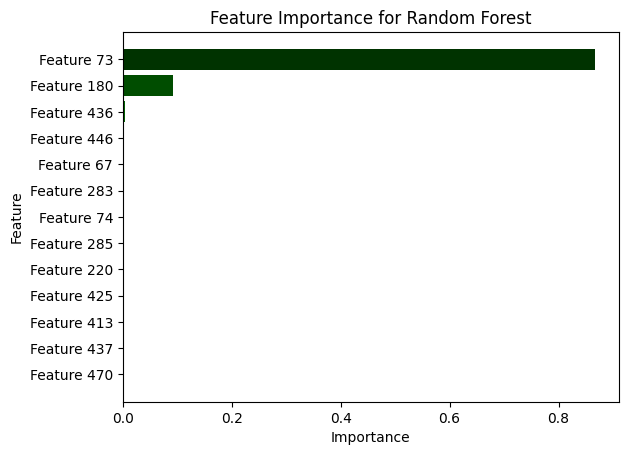

In [30]:
feature_names = X_train_aridity.columns[:-6].tolist() + [f'Feature {i}' for i in range(len(X_train_aridity.columns[:-6]), len(bst.feature_importances_))]
feats_with_imps = sorted(list(zip(feature_names, bst.feature_importances_)), key=lambda x : x[1])
feats, imps = zip(*feats_with_imps[-13:])
colors = ['#ccffcc', '#99ff99', '#66ff66', '#33ff33', '#00ff00', '#00e600', '#00cc00', '#00b300', '#009900', '#007f00', '#006600', '#004d00', '#003300']
plt.barh(feats, imps, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest')
plt.show()

In [31]:
merra2_features = []

for feat, imp in feats_with_imps:
    if feat[:7] != 'Feature':
        merra2_features.append((feat, imp))

merra2_features

[('DUEXTTAU', np.float32(0.000105005456)),
 ('OCSMASS', np.float32(0.00012359102)),
 ('U2M', np.float32(0.00012605262)),
 ('SSSMASS25', np.float32(0.00013045075)),
 ('SSEXTTAU', np.float32(0.00013791825)),
 ('TOTEXTTAU', np.float32(0.00014106251)),
 ('PBLH', np.float32(0.00014242347)),
 ('V2M', np.float32(0.00014773192)),
 ('SUEXTTAU', np.float32(0.00015365833)),
 ('Q500', np.float32(0.00015513346)),
 ('T10M', np.float32(0.00016505194)),
 ('DUSMASS', np.float32(0.00017050932)),
 ('BCEXTTAU', np.float32(0.0001800384)),
 ('SSSMASS', np.float32(0.0001862062)),
 ('BCSMASS', np.float32(0.00019034874)),
 ('Q850', np.float32(0.00019380882)),
 ('SO4SMASS', np.float32(0.00020275958)),
 ('QV10M', np.float32(0.00021508896)),
 ('U10M', np.float32(0.00021618255)),
 ('OCEXTTAU', np.float32(0.00022118539)),
 ('V10M', np.float32(0.00024123924)),
 ('T500', np.float32(0.00025915573)),
 ('T850', np.float32(0.00031113613)),
 ('DUSMASS25', np.float32(0.0003219941)),
 ('QV2M', np.float32(0.00033190203)),
 (

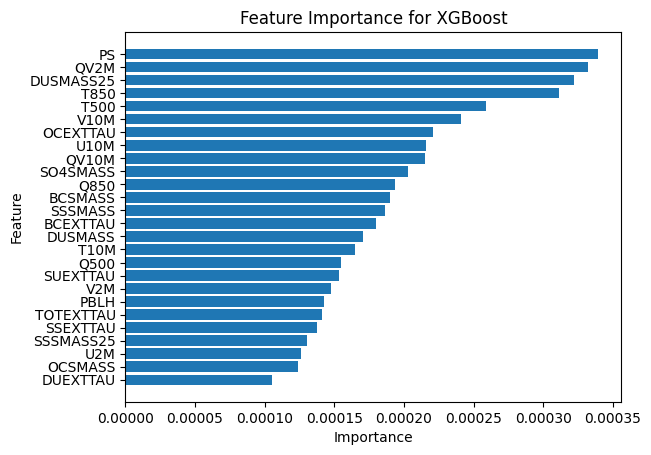

In [33]:
merra2_feats, merra2_imps = zip(*merra2_features)
plt.barh(merra2_feats, merra2_imps)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for XGBoost')
plt.show()

In [78]:
features = [15, 23, 12, 21, 14, 20, 9, 22, 24, 10, 18, 4, 2, 7, 11, 17, 16, 8, 19, 25, 6, 5, 1, 13, 3, 0]
X_train_aridity.columns[features]

Index(['PS', 'QV2M', 'DUSMASS25', 'T850', 'T500', 'V10M', 'OCEXTTAU', 'U10M',
       'QV10M', 'SO4SMASS', 'Q850', 'BCSMASS', 'SSSMASS', 'BCEXTTAU',
       'DUSMASS', 'T10M', 'Q500', 'SUEXTTAU', 'V2M', 'PBLH', 'TOTEXTTAU',
       'SSEXTTAU', 'SSSMASS25', 'U2M', 'OCSMASS', 'DUEXTTAU'],
      dtype='object')

## Random Forest

In [6]:
X_train = np.load(nn_data_dir + 'aridity/X_train_aridity.npy').astype(np.float32)
y_train = np.load(nn_data_dir + 'aridity/y_train_aridity.npy')
X_val = np.load(nn_data_dir + 'aridity/X_val_aridity.npy').astype(np.float32)
y_val = np.load(nn_data_dir + 'aridity/y_val_aridity.npy')
neural_net = AridityModel(len(X_train[0])).to('cpu')
load_checkpoint(neural_net, 5, 200)
X_train_embedded = neural_net.embedding(torch.tensor(X_train)).detach().numpy()
X_train_final = np.concat([X_train[:, :-6], X_train_embedded], axis=1)
X_val_embedded = neural_net.embedding(torch.tensor(X_val)).detach().numpy()
X_val_final = np.concat([X_val[:, :-6], X_val_embedded], axis=1)

In [12]:
rf = RandomForestRegressor(verbose=1, n_estimators=100, max_depth=10, n_jobs=4)
rf.fit(X_train_final, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:  9.1min finished


RandomForestRegressor(max_depth=10, n_jobs=4, verbose=1)

In [ ]:
print(f'Training MSE: {mean_squared_error(y_train, rf.predict(X_train_final))}')
print(f'Validation MSE: {mean_squared_error(y_val, rf.predict(X_val_final))}')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.5s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s


Training MSE: 1420.1581129465117
Validation MSE: 1654.4102922662278


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [ ]:
joblib.dump(rf, 'rf.pkl')

['rf.pkl']

In [4]:
rf = joblib.load('rf.pkl')

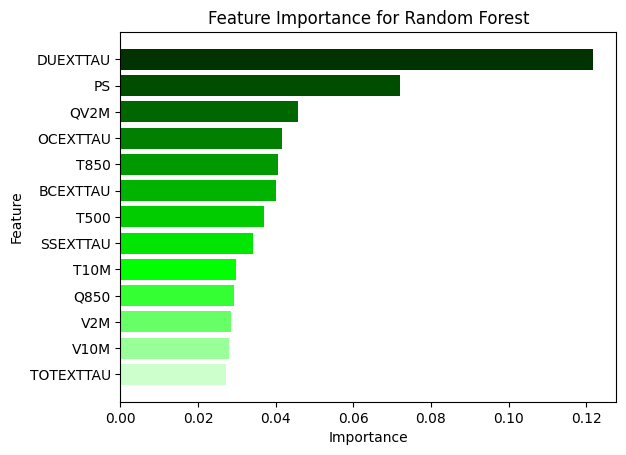

In [34]:
feature_names = X_train_aridity.columns.tolist()[:-6] + [f'Feature {i}' for i in range(len(X_train_aridity.columns[:-6]), len(rf.feature_importances_))]
feats_with_imps = sorted(list(zip(feature_names, rf.feature_importances_)), key=lambda x : x[1])
feats, imps = zip(*feats_with_imps[-13:])
colors = ['#ccffcc', '#99ff99', '#66ff66', '#33ff33', '#00ff00', '#00e600', '#00cc00', '#00b300', '#009900', '#007f00', '#006600', '#004d00', '#003300']
plt.barh(feats, imps, color=colors)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest')
plt.show()

In [36]:
merra2_features = []

for feat, imp in feats_with_imps:
    if feat[:7] != 'Feature':
        merra2_features.append((feat, imp))

merra2_features

[('SSSMASS25', np.float64(0.0)),
 ('OCSMASS', np.float64(0.0)),
 ('BCSMASS', np.float64(0.0)),
 ('SO4SMASS', np.float64(0.0)),
 ('SSSMASS', np.float64(1.7760261366352588e-06)),
 ('DUSMASS25', np.float64(0.00017515476056868034)),
 ('DUSMASS', np.float64(0.010795166460813325)),
 ('Q500', np.float64(0.016188360387601276)),
 ('QV10M', np.float64(0.01796628058412894)),
 ('U2M', np.float64(0.018809086497594118)),
 ('PBLH', np.float64(0.018955965281065447)),
 ('U10M', np.float64(0.019993518952571992)),
 ('SUEXTTAU', np.float64(0.023962134911005142)),
 ('TOTEXTTAU', np.float64(0.027165676429505802)),
 ('V10M', np.float64(0.02808632076552225)),
 ('V2M', np.float64(0.02836534808972965)),
 ('Q850', np.float64(0.029225834242599516)),
 ('T10M', np.float64(0.029759528008868375)),
 ('SSEXTTAU', np.float64(0.0340458177062913)),
 ('T500', np.float64(0.0369175145587859)),
 ('BCEXTTAU', np.float64(0.040100654687790234)),
 ('T850', np.float64(0.04050117113056804)),
 ('OCEXTTAU', np.float64(0.0416872392202

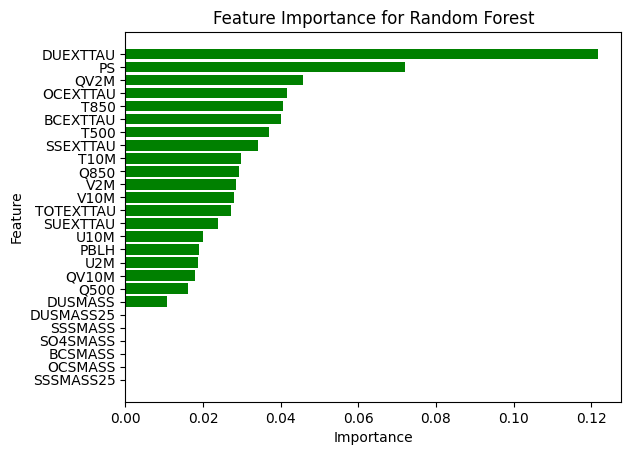

In [40]:
merra2_feats, merra2_imps = zip(*merra2_features)
plt.barh(merra2_feats, merra2_imps, color = 'green')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest')
plt.show()

In [82]:
features = [0, 15, 23, 9, 21, 7, 14, 5, 17, 18, 19, 20, 6, 8, 22, 25, 24, 16, 11, 12, 2, 10, 4, 3, 1]
X_train_aridity.columns[features]

Index(['DUEXTTAU', 'PS', 'QV2M', 'OCEXTTAU', 'T850', 'BCEXTTAU', 'T500',
       'SSEXTTAU', 'T10M', 'Q850', 'V2M', 'V10M', 'TOTEXTTAU', 'SUEXTTAU',
       'U10M', 'PBLH', 'QV10M', 'Q500', 'DUSMASS', 'DUSMASS25', 'SSSMASS',
       'SO4SMASS', 'BCSMASS', 'OCSMASS', 'SSSMASS25'],
      dtype='object')

## NN

In [3]:
X_train = np.load(nn_data_dir + 'aridity/X_train_aridity.npy').astype(np.float32)
y_train = np.load(nn_data_dir + 'aridity/y_train_aridity.npy')
X_val = np.load(nn_data_dir + 'aridity/X_val_aridity.npy').astype(np.float32)
y_val = np.load(nn_data_dir + 'aridity/y_val_aridity.npy')
train_dataset = OpenAQDataset(X_train, y_train)
val_dataset = OpenAQDataset(X_val, y_val)

In [ ]:
train_losses = []
val_losses = []
epochs = list(range(5, 505, 5))

for epoch in tqdm(range(5, 505, 5)):
    nn = AridityModel(len(X_train[0])).to(device)
    load_checkpoint(nn, 4, epoch)

    train_losses.append(evaluate(nn, train_dataset))
    val_losses.append(evaluate(nn, val_dataset))

100%|██████████| 100/100 [03:14<00:00,  1.94s/it]


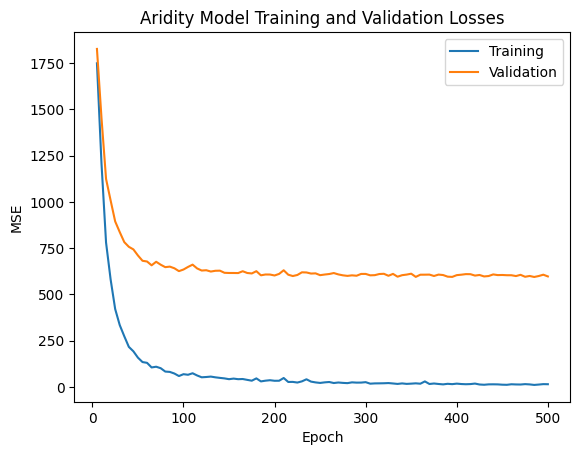

In [ ]:
plt.plot(epochs, train_losses, label='Training')
plt.plot(epochs, val_losses, label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Aridity Model Training and Validation Losses')
plt.show()

100%|██████████| 5/5 [00:10<00:00,  2.03s/it]


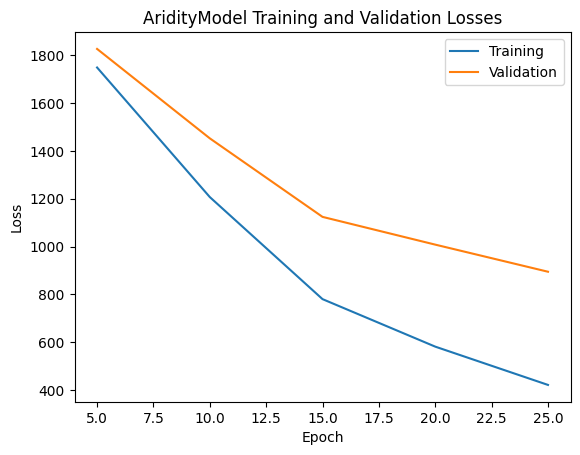

In [ ]:
plot_losses(train_dataset, val_dataset, AridityModel(len(X_train[0])), 4, 5, 25)

In [11]:
neural_net = AridityModel(len(X_train[0]))
load_checkpoint(neural_net, 5, 200)

In [12]:
def model_predict(x):
    neural_net.eval()
    with torch.no_grad():
        inputs = torch.tensor(x)
        output = neural_net(inputs)
        return output.numpy()

In [13]:
background_samples = shap.sample(X_train, 100, 497)
explainer = shap.KernelExplainer(model_predict, background_samples)

In [14]:
background_samples_test = shap.sample(X_val, 100, 497)

In [15]:
shap_values_test = explainer(background_samples_test)

  0%|          | 0/100 [00:00<?, ?it/s]

In [16]:
shap_values_test.feature_names = X_train_aridity.columns.values
shap_values_test.feature_names

array(['DUEXTTAU', 'SSSMASS25', 'SSSMASS', 'OCSMASS', 'BCSMASS',
       'SSEXTTAU', 'TOTEXTTAU', 'BCEXTTAU', 'SUEXTTAU', 'OCEXTTAU',
       'SO4SMASS', 'DUSMASS', 'DUSMASS25', 'U2M', 'T500', 'PS', 'Q500',
       'T10M', 'Q850', 'V2M', 'V10M', 'T850', 'U10M', 'QV2M', 'QV10M',
       'PBLH', 'site', 'season', 'hour', 'day', 'month', 'aridity'],
      dtype=object)

In [17]:
np.random.seed(497)
data_point = np.random.randint(0, 100)
data_point

50

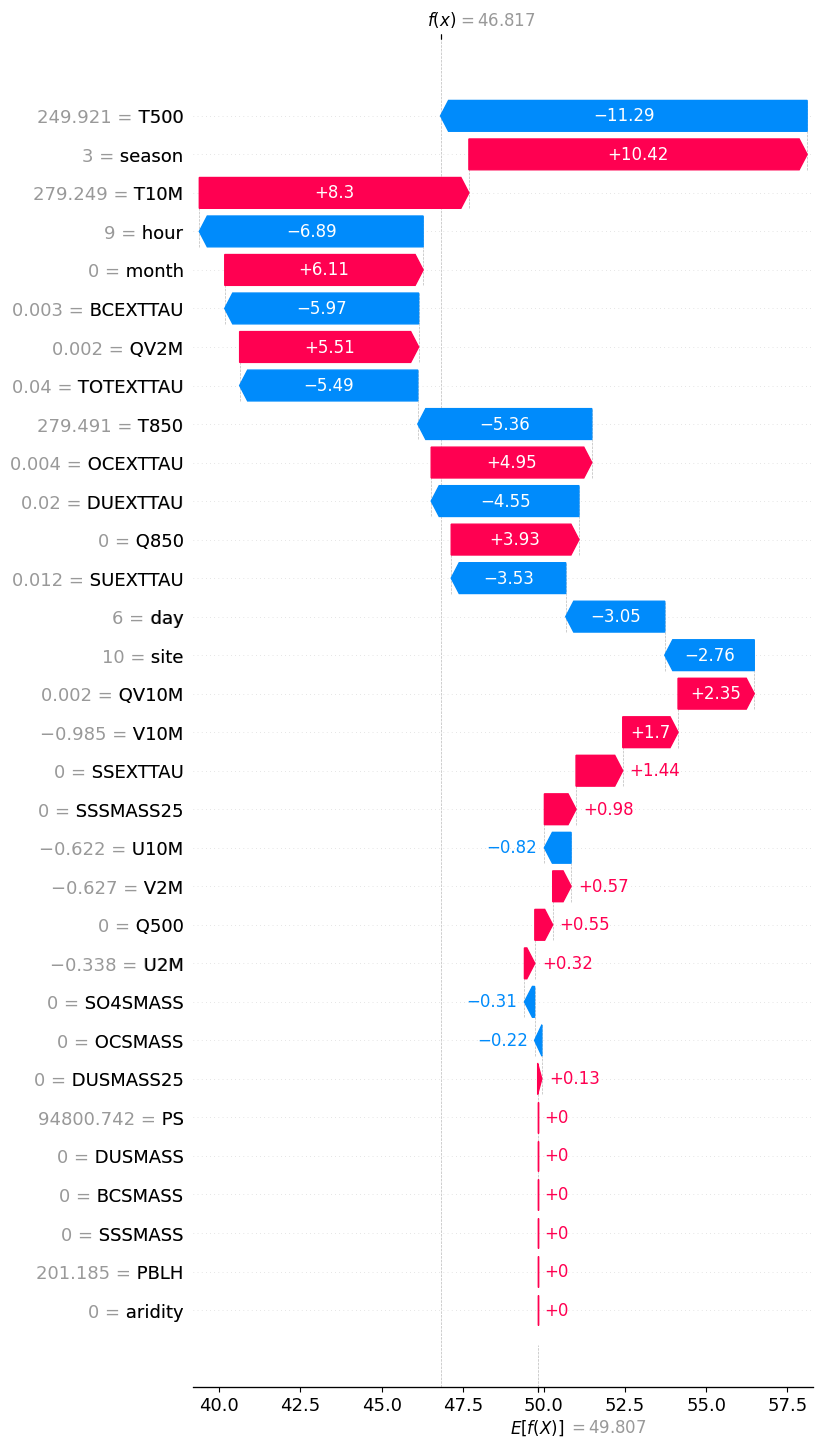

In [18]:
shap.plots.waterfall(shap_values_test[data_point, :, 0], max_display=32)

In [19]:
np.random.seed(496)
data_point2 = np.random.randint(0, 100)
data_point2

57

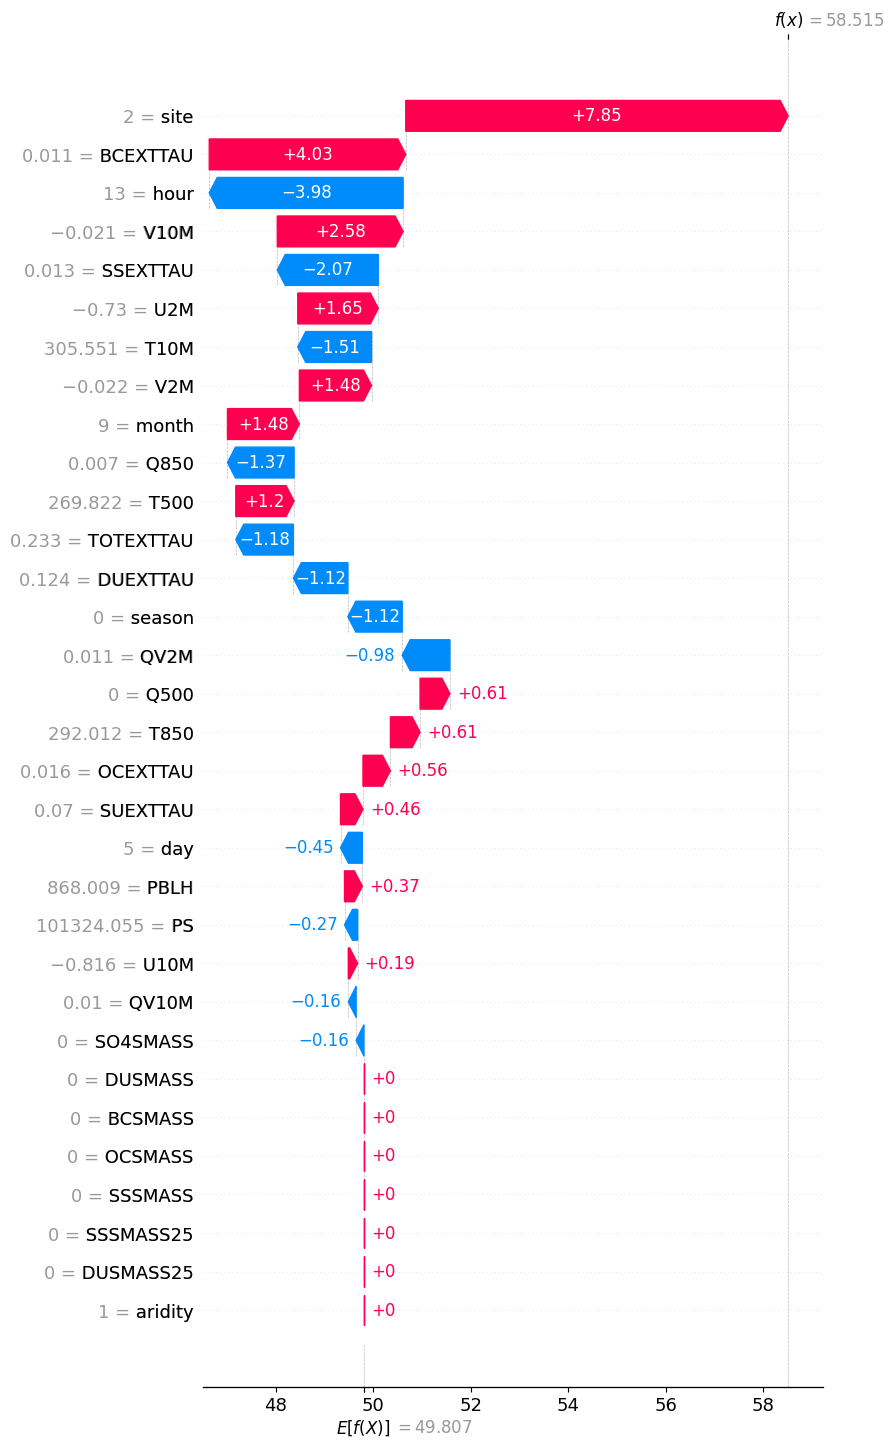

In [20]:
shap.plots.waterfall(shap_values_test[data_point2, :, 0], max_display=32)

In [21]:
np.random.seed(495)
data_point3 = np.random.randint(0, 100)
data_point3

25

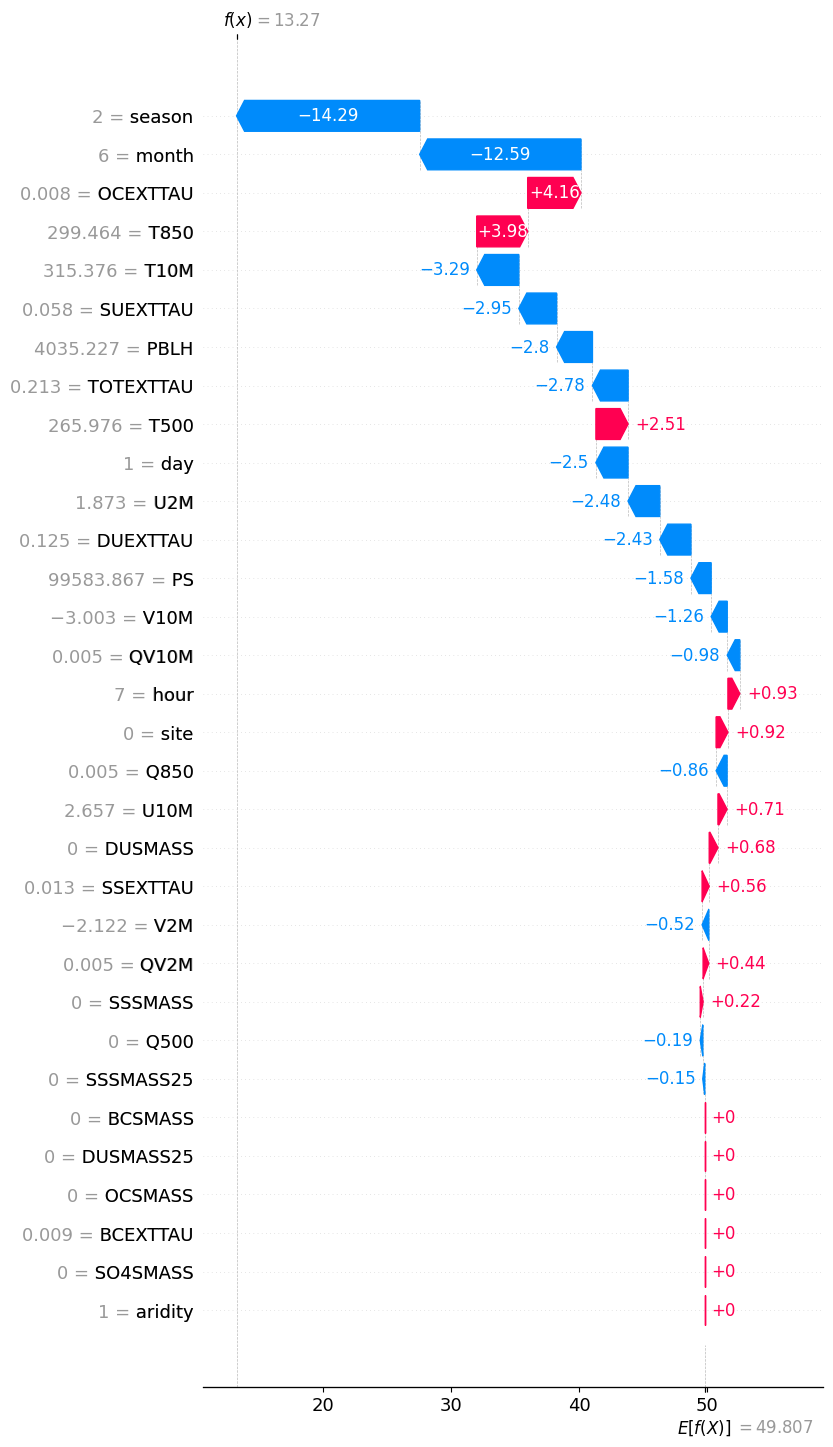

In [22]:
shap.plots.waterfall(shap_values_test[data_point3, :, 0], max_display=32)

In [37]:
shap_values_test_agg = np.mean(shap_values_test.values, axis=0)[:, 0]
shap_values_test_agg

array([-2.03307478e-02,  6.97836248e-03,  5.44993424e-02, -2.88731566e-02,
        0.00000000e+00, -4.65269333e-01, -1.39082521e-01, -5.00047717e-01,
       -2.47431523e-01,  5.74226853e-01, -5.51034665e-02, -1.21246105e-02,
        7.70806703e-02, -1.40718086e-01, -6.57794161e-01, -7.71497657e-01,
       -1.26167438e-01,  6.60815431e-01, -8.72728437e-02,  2.37677292e-01,
        1.02293129e-01,  1.55320835e+00, -3.65620236e-01, -6.79865139e-02,
        7.21576599e-03, -4.87346299e-01,  9.44179466e-01, -1.38750040e-01,
       -9.06325140e-01,  1.36892777e-01,  9.52953320e-01,  6.25081066e-04])

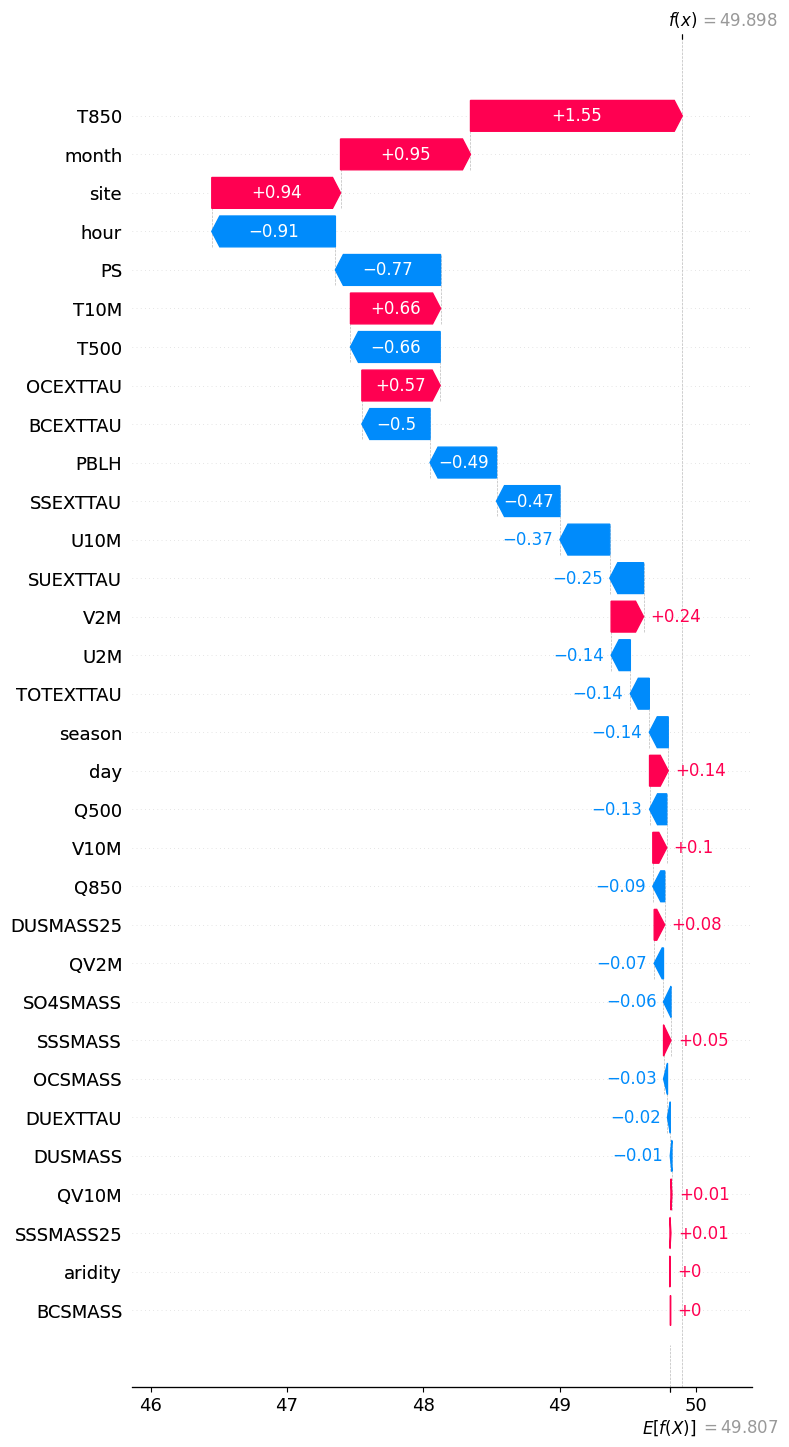

In [46]:
shap_values_test_agg_explanation = shap.Explanation(values=shap_values_test_agg, feature_names=X_train_aridity.columns.values, base_values=shap_values_test.base_values[0][0])
shap.plots.waterfall(shap_values_test_agg_explanation, max_display=32)

In [ ]:
neural_net = AridityModel()

NameError: name 'neural_net' is not defined